# Libraries and functions

In [1]:
import matplotlib.pyplot as plt
import plotly.express as px
import random
import numpy as np
import pandas as pd
import glob
import tensorflow as tf
import keras
import keras_tuner as kt
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report

random.seed(0)
keras.utils.set_random_seed(0)

## Functions description



1. **plot_history(history)**

This function plots the training and validation loss and accuracy over epochs.

- **Purpose:** To visualize the performance of a model during the training and validation phases.
- **Parameters:** 
  - `history`: A history object returned by `model.fit()` in Keras, containing the loss and accuracy for both training and validation datasets across epochs.
- **Functionality:**
  - Creates a figure with dimensions 14x6 inches.
  - Generates two subplots: one for plotting the loss and the other for plotting the accuracy.
  - Plots training (`loss`, `accuracy`) and validation (`val_loss`, `val_accuracy`) metrics.
  - Sets the y-axis limits for loss between 0.0 and 2.0 and for accuracy between 0.5 and 1.0.
  - Adds labels and legends for better readability.

2. **save(history, model, name)**

This function saves the trained model and its training history to files.

- **Purpose:** To persist the trained model and its training history for future use or analysis.
- **Parameters:**
  - `history`: The history object containing training metrics.
  - `model`: The trained Keras model.
  - `name`: A string used to name the saved files.
- **Functionality:**
  - Saves the model to a file with the extension `.keras`.
  - Converts the training history to a pandas DataFrame and saves it as a CSV file.

3. **print_confusion_matrix(model, test, classes)**

This function computes and plots a confusion matrix based on the model's predictions.

- **Purpose:** To visualize the performance of a classification model by displaying the confusion matrix.
- **Parameters:**
  - `model`: The trained Keras model.
  - `test`: The test dataset.
  - `classes`: A list of class names.
- **Functionality:**
  - Iterates over the test dataset to collect true labels and predicted labels.
  - Concatenates these labels into single arrays.
  - Converts one-hot encoded true labels into single labels.
  - Computes the confusion matrix using `scikit-learn`'s `confusion_matrix` function.
  - Plots the confusion matrix with appropriate labels, title, and color annotations.

4. **plot_images_with_predictions(images, true_labels, predicted_labels, class_names)**

This function plots images with their true and predicted labels.

- **Purpose:** To visually inspect the model's predictions by showing some images along with their true and predicted labels.
- **Parameters:**
  - `images`: A list or array of images to be displayed.
  - `true_labels`: The true labels for the images.
  - `predicted_labels`: The predicted labels from the model.
  - `class_names`: A list of class names corresponding to the label indices.
- **Functionality:**
  - Creates a figure with dimensions 12x12 inches.
  - Iterates over the provided images, displaying each image in a subplot.
  - Displays the true and predicted labels below each image, coloring the label green if the prediction is correct and red if it is incorrect.
  - Removes axis ticks and grid for a cleaner presentation.
  - Adjusts the layout to prevent overlap.

These functions provide essential tools for evaluating and understanding the performance of machine learning models in image classification tasks. They offer ways to visualize training progress, save models and training histories, analyze model predictions, and inspect individual predictions in a visual format.

In [2]:
def plot_history(history):
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.ylim([0.0, 2.0])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['train', 'test'])

    plt.subplot(1, 2, 2)
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.ylim([0.5, 1.0])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['train', 'test'])


def save(history, model, name):
    model.save(f'{name}.keras')
    history_df = pd.DataFrame(history.history)
    history_df.to_csv(f'training_history_{name}.csv', index=False)


def print_confusion_matrix(model, test, classes):
    y_pred = []  # store predicted labels
    y_true = []  # store true labels

    for image_batch, label_batch in test:   # use dataset.unbatch() with repeat
       y_true.append(label_batch)
       preds = model.predict(image_batch, verbose=0)
       # append predicted labels
       y_pred.append(np.argmax(preds, axis=-1))

    # Convert lists of batches to single arrays
    correct_labels = tf.concat([item for item in y_true], axis=0)
    predicted_labels = tf.concat([item for item in y_pred], axis=0)

    # Convert one-hot encoded labels to single labels
    correct_labels = np.argmax(correct_labels, axis=-1)

    # Confusion matrix
    cm = confusion_matrix(correct_labels, predicted_labels)

    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes, rotation=45)

    # Loop over data dimensions and create text annotations.
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Ground Truth Class')
    plt.xlabel('Predicted Class')
    plt.tight_layout()
    plt.show()

    return correct_labels, predicted_labels

def plot_images_with_predictions(images, true_labels, predicted_labels, class_names):
    plt.figure(figsize=(12, 12))
    for i in range(len(images)):
        plt.subplot(4, 3, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i].astype("uint8"))
        true_label = class_names[true_labels[i]]
        predicted_label = class_names[predicted_labels[i]]
        color = 'green' if true_label == predicted_label else 'red'
        plt.xlabel(f"Truth: {true_label}\nPrediction: {predicted_label}", color=color)
    plt.tight_layout()
    plt.show()

#  Hyperparameter and architecture research

## Import and split dataset

### Dataset Preparation

The following code snippet performs several key tasks:
- Loads the dataset from a directory.
- Splits the dataset into training and test sets.
- Prepares the datasets for use in a Keras model.

1. **Loading Dataset Paths**

- **Purpose:** To identify all subfolders (classes) within the main dataset directory.
- **Functionality:**
  - `path` defines the root directory containing the dataset.
  - `glob.glob` is used to list all subdirectories within the specified path.
  - `classes` list is populated with the names of the subdirectories, representing different classes of flowers.

2. **Creating Training and Validation Sets**

- **Purpose:** To load and split the dataset into training and test sets.
- **Parameters:**
  - `path`: The directory where the dataset is located.
  - `image_size`: The size to which all images will be resized (224x224).
  - `batch_size`: The number of images per batch (32).
  - `label_mode`: Specifies that the labels are categorical.
  - `subset`: Indicates that both training and test subsets should be created.
  - `validation_split`: The fraction of the data to be used for test (15%).
  - `shuffle`: Indicates that the data should be shuffled.
  - `seed`: A seed for the random number generator to ensure reproducibility.

3. **Printing Dataset Sizes**

- **Purpose:** To print the sizes of the training and test sets.

This code is essential for preparing the dataset for training a machine learning model. It ensures that the dataset is properly organized and split into appropriate subsets for training and testing the model, thereby facilitating effective model training and test.

Found 3670 files belonging to 5 classes.
Using 2569 files for training.
Using 1101 files for validation.
training set size: 2569
validation set size: 544
test set size: 557


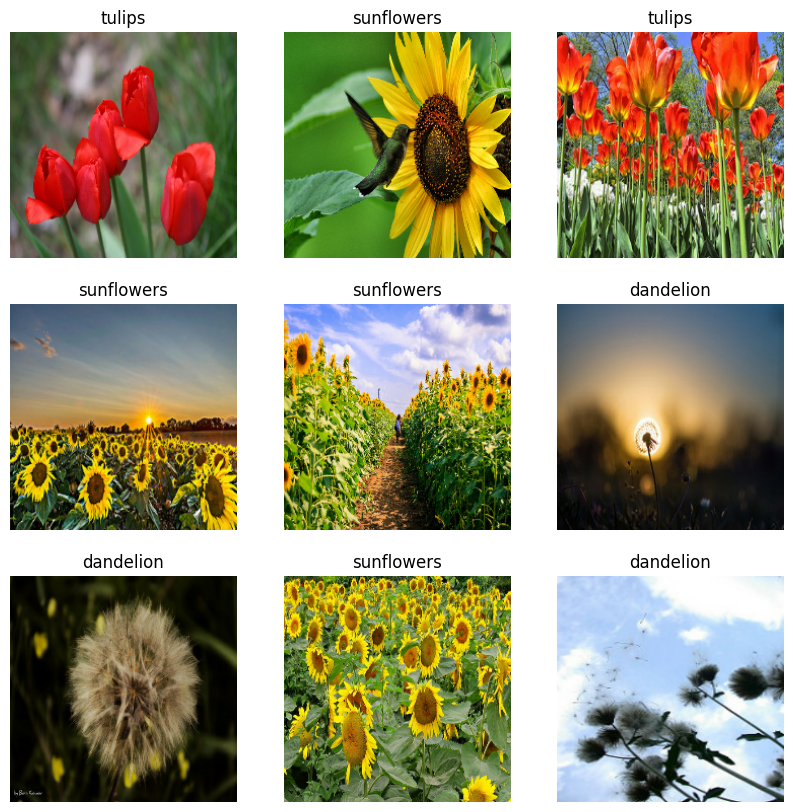

In [2]:
# Creation of a new dataset (only training and test set)
path = "dataset/flower_photos"
subfolders = glob.glob(pathname = f'{path}/*', recursive = True)

classes = []

for subfolder in subfolders:
    classes.append(subfolder.split(f'{path}\\')[1])

train, validation = keras.utils.image_dataset_from_directory(path,
                                                       image_size=(224,224),
                                                       batch_size=32,
                                                       label_mode='categorical',
                                                       subset='both',
                                                       validation_split = 0.30,
                                                       shuffle=True,
                                                       seed=0)

plt.figure(figsize=(10, 10))
for images, labels in validation.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(classes[np.argmax(labels[i])])
        plt.axis("off")

splitSize =  tf.data.experimental.cardinality(validation) // 2
test = validation.skip(splitSize)
validation = validation.take(splitSize)

print("training set size:", len(list(train.unbatch())))
print("validation set size:", len(list(validation.unbatch())))
print("test set size:", len(list(test.unbatch())))

Found 3670 files belonging to 5 classes.
Using 2569 files for training.
Using 1101 files for validation.
training set size: 2569
validation set size: 544
test set size: 557


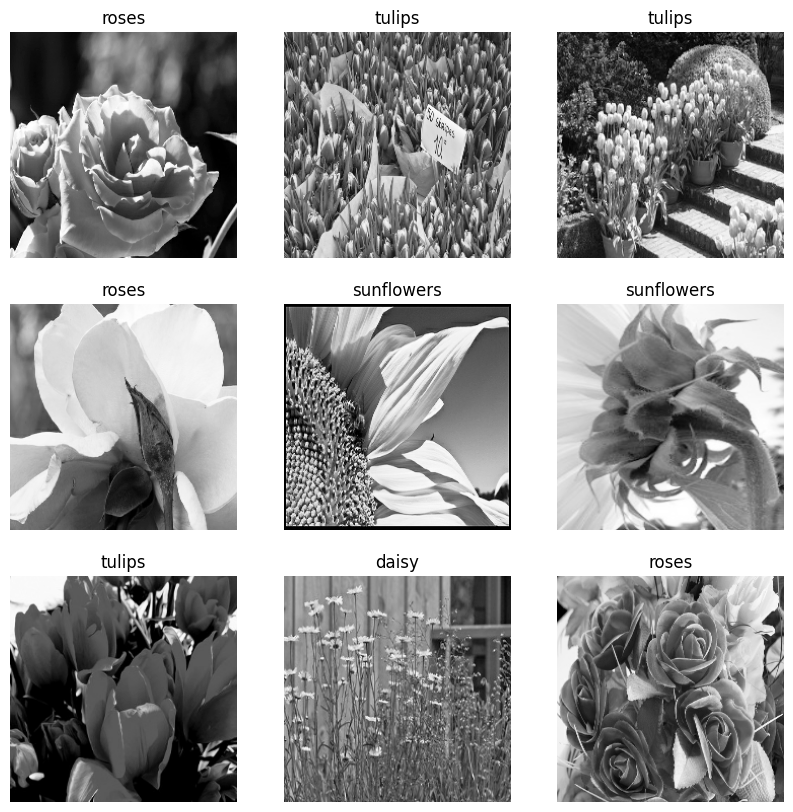

In [3]:
# Creation of a new dataset (only training and test set and with grayscale)
trainGray, validationGray = keras.utils.image_dataset_from_directory(path,
                                                               image_size=(224,224),
                                                               color_mode="grayscale",
                                                               batch_size=32,
                                                               label_mode='categorical',
                                                               subset='both',
                                                               validation_split = 0.30,
                                                               shuffle=True,
                                                               seed=0)

plt.figure(figsize=(10, 10))
for images, labels in trainGray.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"), cmap='Greys_r')
        plt.title(classes[np.argmax(labels[i])])
        plt.axis("off")

splitSize =  tf.data.experimental.cardinality(validationGray) // 2
testGray = validationGray.skip(splitSize)
validationGray = validationGray.take(splitSize)

print("training set size:", len(list(train.unbatch())))
print("validation set size:", len(list(validation.unbatch())))
print("test set size:", len(list(test.unbatch())))

## Architecture v1

### Model Architecture and Training

The following code snippet performs several key tasks:
- Defines the architecture of a CNN model.
- Compiles the model with appropriate loss function, optimizer, and evaluation metrics.
- Trains the model using the prepared training and validation datasets.

### 1. Model Architecture

- **Purpose:** To define a basic CNN architecture for image classification.
- **Functionality:**
  - **Regularizer:** `keras.regularizers.L1L2(0.001)` applies both L1 and L2 regularization to prevent overfitting.
  - **Input Layer:** `keras.Input((224,224,3))` defines the input shape for the model (224x224 pixels, 3 color channels).
  - **First Convolutional Layer:**
    - `keras.layers.Conv2D(16, 3, padding="same", kernel_regularizer=regularizer)`: Adds a convolutional layer with 16 filters, kernel size of 3x3, same padding, and L1L2 regularization.
    - `keras.layers.BatchNormalization()`: Normalizes the output of the convolutional layer.
    - `keras.layers.Activation("relu")`: Applies the ReLU activation function.
    - `keras.layers.MaxPooling2D(3, strides=3, padding="same")`: Reduces the spatial dimensions using max pooling.
  - **Second Convolutional Layer:**
    - `keras.layers.Conv2D(32, 3, padding="same", kernel_regularizer=regularizer)`: Adds a convolutional layer with 32 filters.
    - `keras.layers.BatchNormalization()`: Normalizes the output.
    - `keras.layers.Activation("relu")`: Applies the ReLU activation function.
    - `keras.layers.MaxPooling2D(3, strides=3, padding="same")`: Reduces the spatial dimensions.
  - **Global Max Pooling:**
    - `keras.layers.GlobalMaxPooling2D()`: Reduces each feature map to a single value.
  - **Fully Connected Layers:**
    - `keras.layers.Dense(16, activation="relu", kernel_regularizer=regularizer)`: Adds a dense layer with 16 units and ReLU activation.
    - `keras.layers.Dense(len(classes), activation="softmax", kernel_regularizer=regularizer)`: Adds an output dense layer with units equal to the number of classes, using softmax activation for classification.

### 2. Model Compilation

- **Purpose:** To configure the model for training by specifying the loss function, optimizer, and evaluation metrics.
- **Functionality:**
  - **Loss Function:** `keras.losses.categorical_crossentropy` is used for multi-class classification tasks.
  - **Optimizer:** `keras.optimizers.Adam(learning_rate=0.001)` is an adaptive learning rate optimizer that adjusts the learning rate during training.
  - **Metrics:** `['accuracy']` specifies that accuracy should be used as a metric to evaluate the model's performance.

### 3. Model Training

- **Purpose:** To train the compiled model using the training dataset and validate it using the validation dataset.
- **Parameters:**
  - `train`: The training dataset.
  - `epochs`: Number of complete passes through the training dataset (30 epochs).
  - `validation_data`: The validation dataset used to evaluate the model after each epoch.
  - `batch_size`: Number of samples per gradient update (64).

**Functionality:**
- **Training Process:**
  - The model iterates over the training data for the specified number of epochs.
  - After each epoch, the model's performance is evaluated on the validation data.
  - The `history` object captures the training and validation loss and accuracy for each epoch, which can be used for further analysis and visualization.

These functions and code segments collectively create, compile, and train a convolutional neural network for image classification tasks. The architecture is designed to handle the complexities of image data, while the compilation and training processes ensure the model learns effectively and can be evaluated using appropriate metrics.

In [44]:
# Creation of the basic architecture model
regularizer = keras.regularizers.L1L2(0.001)

inputs = keras.Input((224,224,3))

x = inputs
x = keras.layers.Conv2D(16, 3, padding="same", kernel_regularizer=regularizer)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(32, 3, padding="same", kernel_regularizer=regularizer)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.GlobalMaxPooling2D()(x)

x = keras.layers.Dense(16, activation="relu", kernel_regularizer=regularizer)(x)

outputs = keras.layers.Dense(len(classes), activation="softmax", kernel_regularizer=regularizer)(x)
model = keras.Model(inputs, outputs)

# Compile the model
model.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.Adam(learning_rate=0.001),
            metrics=['accuracy'])

# Training the model
history = model.fit(train,
          epochs=30,
          validation_data=validation,
          batch_size=64)

Epoch 1/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 31s 303ms/step - accuracy: 0.3240 - loss: 2.7193 - val_accuracy: 0.3964 - val_loss: 1.8581
Epoch 2/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 29s 299ms/step - accuracy: 0.5827 - loss: 1.4421 - val_accuracy: 0.6073 - val_loss: 1.3861
Epoch 3/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 28s 289ms/step - accuracy: 0.6380 - loss: 1.2939 - val_accuracy: 0.6091 - val_loss: 1.2775
Epoch 4/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 28s 289ms/step - accuracy: 0.6688 - loss: 1.2235 - val_accuracy: 0.6073 - val_loss: 1.2851
Epoch 5/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 28s 284ms/step - accuracy: 0.6888 - loss: 1.1658 - val_accuracy: 0.6182 - val_loss: 1.3047
Epoch 6/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 28s 284ms/step - accuracy: 0.6877 - loss: 1.1323 - val_accuracy: 0.6327 - val_loss: 1.2350
Epoch 7/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 29s 293ms/step - accuracy: 0.7110 - loss: 1.0858 - val_accuracy: 0.6400 - val_loss: 1.1785
Epoch 8/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 28s 287ms/step - accuracy: 0.7333 - loss: 1.0464 - val_accu

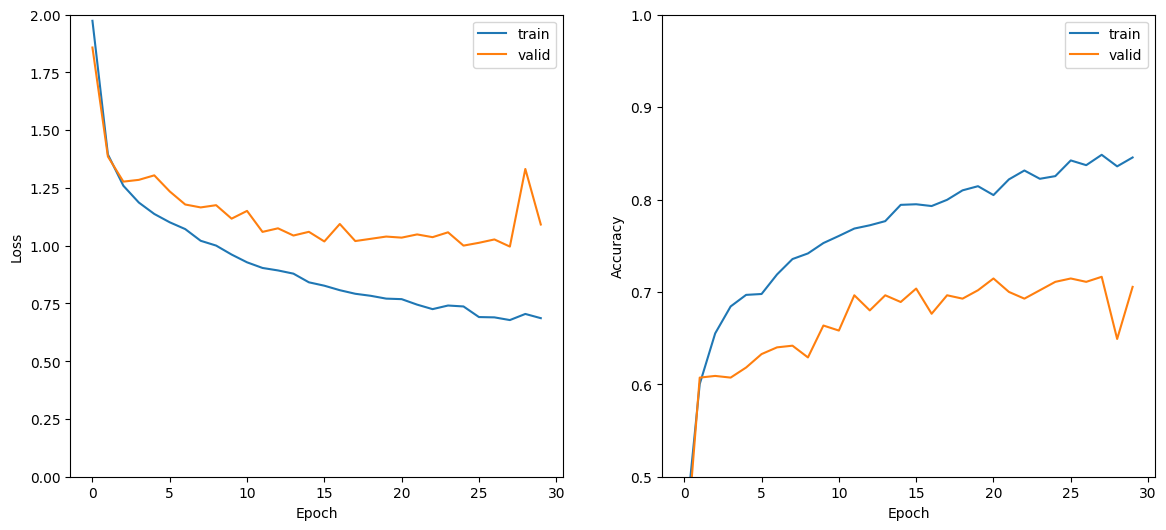

In [45]:
plot_history(history.history)
save(history, model, 'architectureV1')

## Architecture v2 (k = 5)

### Model Architecture and Training

The following code snippet performs several key tasks:
- Defines the architecture of a CNN model with a kernel size of 5x5.
- Compiles the model with appropriate loss function, optimizer, and evaluation metrics.
- Trains the model using the prepared training and validation datasets.

### 1. Model Architecture

- **Purpose:** To define a CNN architecture for image classification using a 5x5 kernel size.
- **Functionality:**
  - **Regularizer:** `keras.regularizers.L1L2(0.001)` applies both L1 and L2 regularization to prevent overfitting.
  - **Input Layer:** `keras.Input((224,224,3))` defines the input shape for the model (224x224 pixels, 3 color channels).
  - **First Convolutional Block:**
    - `keras.layers.Conv2D(16, 5, padding="same", kernel_regularizer=regularizer)`: Adds a convolutional layer with 16 filters, kernel size of 5x5, same padding, and L1L2 regularization.
    - `keras.layers.BatchNormalization()`: Normalizes the output of the convolutional layer.
    - `keras.layers.Activation("relu")`: Applies the ReLU activation function.
    - `keras.layers.MaxPooling2D(5, strides=5, padding="same")`: Reduces the spatial dimensions using max pooling with a 5x5 window.
  - **Second Convolutional Block:**
    - `keras.layers.Conv2D(32, 5, padding="same", kernel_regularizer=regularizer)`: Adds a convolutional layer with 32 filters and a 5x5 kernel size.
    - `keras.layers.BatchNormalization()`: Normalizes the output.
    - `keras.layers.Activation("relu")`: Applies the ReLU activation function.
    - `keras.layers.MaxPooling2D(5, strides=5, padding="same")`: Reduces the spatial dimensions.
  - **Global Max Pooling:**
    - `keras.layers.GlobalMaxPooling2D()`: Reduces each feature map to a single value.
  - **Fully Connected Layers:**
    - `keras.layers.Dense(16, activation="relu", kernel_regularizer=regularizer)`: Adds a dense layer with 16 units and ReLU activation.
    - `keras.layers.Dense(len(classes), activation="softmax", kernel_regularizer=regularizer)`: Adds an output dense layer with units equal to the number of classes, using softmax activation for classification.

In [46]:
# Creation of the model with kernel size equal to 5
regularizer = keras.regularizers.L1L2(0.001)

inputs = keras.Input((224,224,3))

x = inputs
x = keras.layers.Conv2D(16, 5, padding="same", kernel_regularizer=regularizer)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(5, strides=5, padding="same")(x)

x = keras.layers.Conv2D(32, 5, padding="same", kernel_regularizer=regularizer)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(5, strides=5, padding="same")(x)

x = keras.layers.GlobalMaxPooling2D()(x)

x = keras.layers.Dense(16, activation="relu", kernel_regularizer=regularizer)(x)

outputs = keras.layers.Dense(len(classes), activation="softmax", kernel_regularizer=regularizer)(x)
net = keras.Model(inputs, outputs)

# Compile the model 
net.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
            metrics=['accuracy'])

# Training the model
history = net.fit(train,
          epochs=30,
          validation_data=validation,
          batch_size=64)

Epoch 1/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 25s 251ms/step - accuracy: 0.4217 - loss: 2.0097 - val_accuracy: 0.5127 - val_loss: 1.6713
Epoch 2/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 24s 245ms/step - accuracy: 0.6216 - loss: 1.5195 - val_accuracy: 0.5709 - val_loss: 1.5391
Epoch 3/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 24s 242ms/step - accuracy: 0.6811 - loss: 1.3429 - val_accuracy: 0.6055 - val_loss: 1.4019
Epoch 4/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 24s 243ms/step - accuracy: 0.6989 - loss: 1.2153 - val_accuracy: 0.6218 - val_loss: 1.3156
Epoch 5/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 24s 243ms/step - accuracy: 0.7166 - loss: 1.1515 - val_accuracy: 0.5764 - val_loss: 1.4365
Epoch 6/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 24s 244ms/step - accuracy: 0.7280 - loss: 1.1102 - val_accuracy: 0.6091 - val_loss: 1.2904
Epoch 7/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 24s 244ms/step - accuracy: 0.7457 - loss: 1.0418 - val_accuracy: 0.6527 - val_loss: 1.2286
Epoch 8/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 23s 239ms/step - accuracy: 0.7601 - loss: 1.0107 - val_accu

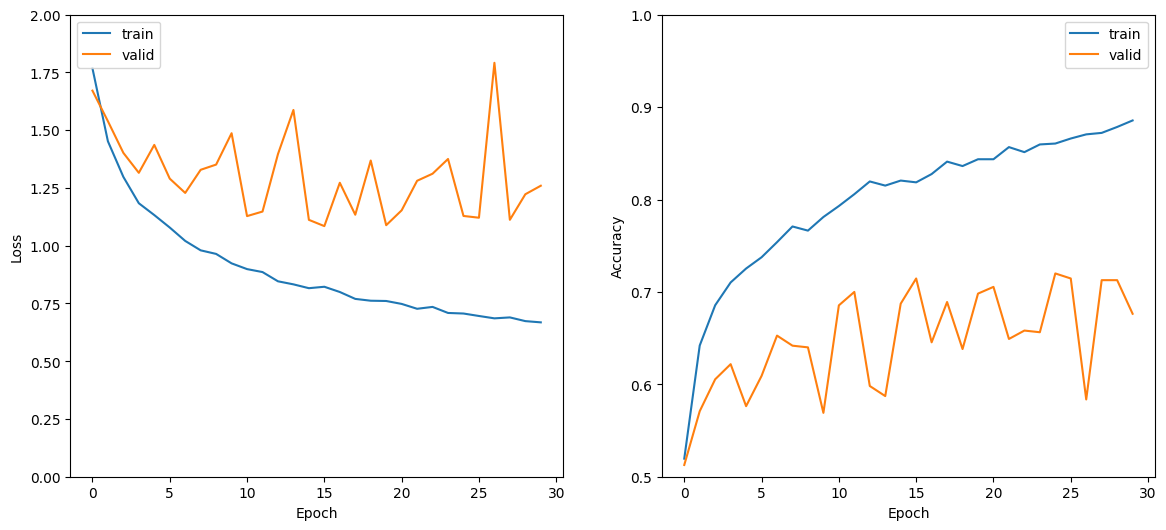

In [47]:
plot_history(history.history)
save(history, model, 'architectureV2')

## Architecture v3 (with preprocessing)

### Model Architecture and Training

The following code snippet performs several key tasks:
- Defines a deeper CNN architecture with data augmentation.
- Compiles the model with appropriate loss function, optimizer, and evaluation metrics.
- Trains the model using the prepared training and validation datasets.

### 1. Model Architecture

- **Purpose:** To define a deeper CNN architecture for image classification with integrated data augmentation techniques.
- **Functionality:**
  - **Regularizer:** `keras.regularizers.L1L2(0.001)` applies both L1 and L2 regularization to prevent overfitting.
  - **Input Layer:** `keras.Input((224,224,3))` defines the input shape for the model (224x224 pixels, 3 color channels).
  - **Data Augmentation Layers:**
    - `keras.layers.RandomFlip("horizontal_and_vertical")`: Randomly flips the images horizontally and vertically.
    - `keras.layers.RandomRotation(0.5)`: Randomly rotates the images.
    - `keras.layers.RandomContrast(0.5)`: Randomly adjusts the contrast of the images.
    - `keras.layers.RandomBrightness(0.5)`: Randomly adjusts the brightness of the images.
  - **Convolutional Blocks:**
    - Each block consists of:
      - `keras.layers.Conv2D`: Adds a convolutional layer with specified filters and kernel size.
      - `keras.layers.BatchNormalization()`: Normalizes the output of the convolutional layer.
      - `keras.layers.Activation("relu")`: Applies the ReLU activation function.
      - `keras.layers.MaxPooling2D(3, strides=3, padding="same")`: Reduces the spatial dimensions using max pooling with a 3x3 window.
  - **Global Max Pooling:**
    - `keras.layers.GlobalMaxPooling2D()`: Reduces each feature map to a single value.
  - **Fully Connected Layers:**
    - `keras.layers.Dense(32, activation="relu", kernel_regularizer=regularizer, kernel_initializer=keras.initializers.HeNormal())`: Adds a dense layer with 32 units, ReLU activation, L1L2 regularization, and HeNormal initializer.
    - `keras.layers.Dense(16, activation="relu", kernel_regularizer=regularizer, kernel_initializer=keras.initializers.HeNormal())`: Adds a dense layer with 16 units.
    - `keras.layers.Dense(8, activation="relu", kernel_regularizer=regularizer, kernel_initializer=keras.initializers.HeNormal())`: Adds a dense layer with 8 units.
    - `keras.layers.Dense(len(classes), activation="softmax", kernel_regularizer=regularizer)`: Adds an output dense layer with units equal to the number of classes, using softmax activation for classification.

In [48]:
# Creation of the model (more deeper and with data augmentation)
regularizer = keras.regularizers.L1L2(0.001)

inputs = keras.Input((224,224,3))

x = inputs

x = keras.layers.RandomFlip("horizontal_and_vertical")(x)
x = keras.layers.RandomRotation(0.5)(x)
x = keras.layers.RandomContrast(0.5)(x)
x = keras.layers.RandomBrightness(0.5)(x)

x = keras.layers.Conv2D(16, 3, padding="same", kernel_regularizer=regularizer)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(16, 3, padding="same", kernel_regularizer=regularizer)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(32, 3, padding="same", kernel_regularizer=regularizer)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.GlobalMaxPooling2D()(x)

x = keras.layers.Dense(32, activation="relu", kernel_regularizer=regularizer, kernel_initializer=keras.initializers.HeNormal())(x)
x = keras.layers.Dense(16, activation="relu", kernel_regularizer=regularizer, kernel_initializer=keras.initializers.HeNormal())(x)
x = keras.layers.Dense(8, activation="relu", kernel_regularizer=regularizer, kernel_initializer=keras.initializers.HeNormal())(x)

outputs = keras.layers.Dense(len(classes), activation="softmax", kernel_regularizer=regularizer)(x)
net = keras.Model(inputs, outputs)

# Compile the model
net.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.Adam(learning_rate=0.001),
            metrics=['accuracy'])

# Training the model
history = net.fit(train,
                  epochs=30,
                  validation_data=validation,
                  batch_size=64)

Epoch 1/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 31s 291ms/step - accuracy: 0.2299 - loss: 2.9020 - val_accuracy: 0.2400 - val_loss: 2.4479
Epoch 2/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 27s 279ms/step - accuracy: 0.2825 - loss: 2.3311 - val_accuracy: 0.2218 - val_loss: 2.4751
Epoch 3/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 27s 277ms/step - accuracy: 0.3558 - loss: 2.1695 - val_accuracy: 0.3927 - val_loss: 2.1710
Epoch 4/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 27s 277ms/step - accuracy: 0.5138 - loss: 1.8949 - val_accuracy: 0.4618 - val_loss: 1.9028
Epoch 5/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 28s 286ms/step - accuracy: 0.5554 - loss: 1.7312 - val_accuracy: 0.5709 - val_loss: 1.7119
Epoch 6/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 27s 278ms/step - accuracy: 0.5761 - loss: 1.6814 - val_accuracy: 0.5927 - val_loss: 1.6091
Epoch 7/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 27s 275ms/step - accuracy: 0.5904 - loss: 1.5910 - val_accuracy: 0.5982 - val_loss: 1.5585
Epoch 8/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 27s 274ms/step - accuracy: 0.6052 - loss: 1.5393 - val_accu

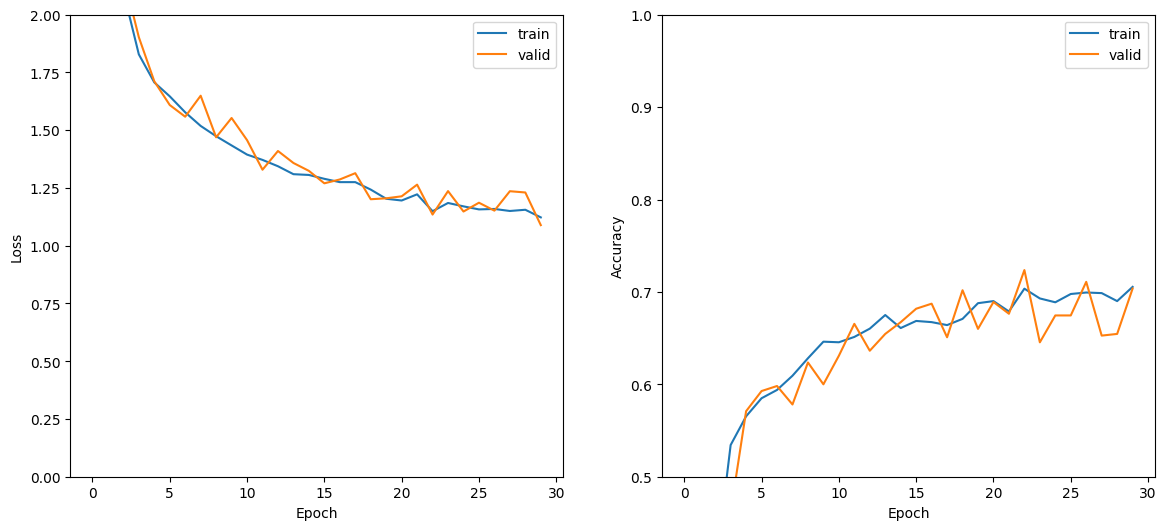

In [49]:
plot_history(history.history)
save(history, model, 'architectureV3')

## Tuning (Hyperband)

### Model Building, Compilation, and Hyperparameter Tuning

The following code snippet performs several key tasks:
- Defines a flexible CNN architecture with data augmentation.
- Compiles the model with an appropriate loss function, optimizer, and evaluation metrics.
- Uses Keras Tuner to optimize hyperparameters.
- Trains the model using the prepared training and validation datasets.

### 1. Model Architecture

- **Purpose:** To define a flexible CNN architecture for image classification with integrated data augmentation techniques and hyperparameter tuning capabilities.
- **Functionality:**
  - **Regularizer:** `keras.regularizers.L1L2(0.0001)` applies both L1 and L2 regularization to prevent overfitting.
  - **Input Layer:** `keras.Input((224,224,3))` defines the input shape for the model (224x224 pixels, 3 color channels).
  - **Data Augmentation Layers:**
    - `keras.layers.RandomFlip("horizontal_and_vertical")`: Randomly flips the images horizontally and vertically.
    - `keras.layers.RandomRotation(0.5)`: Randomly rotates the images.
    - `keras.layers.RandomContrast(0.5)`: Randomly adjusts the contrast of the images.
    - `keras.layers.RandomBrightness(0.5)`: Randomly adjusts the brightness of the images.
    - `keras.layers.RandomZoom(0.2)`: Randomly zooms into the images.
  - **Convolutional Blocks:**
    - Each block consists of:
      - `keras.layers.Conv2D`: Adds a convolutional layer with specified filters (determined by hyperparameter tuning) and kernel size.
      - `keras.layers.BatchNormalization()`: Normalizes the output of the convolutional layer.
      - `keras.layers.Activation("relu")`: Applies the ReLU activation function.
      - `keras.layers.MaxPooling2D(3, strides=3, padding="same")`: Reduces the spatial dimensions using max pooling with a 3x3 window.
  - **Global Max Pooling:**
    - `keras.layers.GlobalMaxPooling2D()`: Reduces each feature map to a single value.
  - **Fully Connected Layers:**
    - `keras.layers.Dense`: Adds dense layers with units determined by hyperparameter tuning, ReLU activation, L1L2 regularization, and HeNormal initializer.
    - `keras.layers.Dense(len(classes), activation="softmax", kernel_regularizer=regularizer)`: Adds an output dense layer with units equal to the number of classes, using softmax activation for classification.

In [6]:
regularizer = keras.regularizers.L1L2(0.0001)

def build_model(hp):
    inputs = keras.Input((224,224,3))

    x = keras.layers.RandomFlip("horizontal_and_vertical")(inputs)
    x = keras.layers.RandomRotation(0.5)(x)
    x = keras.layers.RandomContrast(0.5)(x)
    x = keras.layers.RandomBrightness(0.5)(x)
    x = keras.layers.RandomZoom(0.2)(x)
    
    x = keras.layers.Conv2D(filters=hp.Choice('units_conv_1', [32, 64]), kernel_size=3, padding="same", kernel_regularizer=regularizer)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation("relu")(x)
    x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

    x = keras.layers.Conv2D(filters=hp.Choice('units_conv_2', [64, 128]), kernel_size=3, padding="same", kernel_regularizer=regularizer)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation("relu")(x)
    x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

    x = keras.layers.Conv2D(filters=hp.Choice('units_conv_3', [64, 128]), kernel_size=3, padding="same", kernel_regularizer=regularizer)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation("relu")(x)
    x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

    x = keras.layers.GlobalMaxPooling2D()(x)
    
    x = keras.layers.Dense(units=hp.Choice('units_dense_1', [64, 128]), activation="relu", 
                           kernel_regularizer=regularizer, kernel_initializer=keras.initializers.HeNormal())(x)
    
    x = keras.layers.Dense(units=hp.Choice('units_dense_2', [32, 64]), activation="relu", 
                           kernel_regularizer=regularizer, kernel_initializer=keras.initializers.HeNormal())(x)
    
    x = keras.layers.Dense(units=hp.Choice('units_dense_3', [16, 32]), activation="relu", 
                           kernel_regularizer=regularizer, kernel_initializer=keras.initializers.HeNormal())(x)
    
    outputs = keras.layers.Dense(len(classes), activation="softmax", kernel_regularizer=regularizer)(x)
    model = keras.Model(inputs, outputs)

    # Compile the model
    model.compile(optimizer=keras.optimizers.Adam(),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Training the models
tuner = kt.Hyperband(build_model,
                     objective='val_accuracy',
                     max_epochs=60,
                     factor=3, directory='tuning',
                     project_name='flowers3')

# Early stopping based on validation accuracy with patience
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

# Train the tuner with early stopping callback
tuner.search(train, epochs=60, validation_data=validation, callbacks=[early_stopping])

Trial 89 Complete [00h 16m 18s]
val_accuracy: 0.6912028789520264

Best val_accuracy So Far: 0.7594255208969116
Total elapsed time: 23h 39m 55s


In [21]:
# Visualization of hyperparameters related to best model
best_hps = tuner.get_best_hyperparameters()[0]

for param, value in best_hps.values.items():
    print(f'{param}: {value}')

best_trial = tuner.oracle.get_best_trials()[0]

print(f'Best trial hyperparameters: {best_trial.hyperparameters.values}')
print(f'Best trial score: {best_trial.score}')

units_conv_1: 64
units_conv_2: 64
units_conv_3: 128
units_dense_1: 64
units_dense_2: 64
units_dense_3: 16
tuner/epochs: 60
tuner/initial_epoch: 20
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0068
Best trial hyperparameters: {'units_conv_1': 64, 'units_conv_2': 64, 'units_conv_3': 128, 'units_dense_1': 64, 'units_dense_2': 64, 'units_dense_3': 16, 'tuner/epochs': 60, 'tuner/initial_epoch': 20, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0068'}
Best trial score: 0.7594255208969116


# Final Models

In [4]:
train = train.concatenate(validation)

print("training set size:", len(list(train.unbatch())))

training set size: 3113


## First final model

### Model Building, Compilation, and Training

The following code snippet performs several key tasks:
- Defines a CNN architecture with data augmentation.
- Compiles the model with an appropriate loss function, optimizer, and evaluation metrics.
- Sets up training callbacks to enhance the training process.

### 1. Model Architecture

- **Purpose:** To define a CNN architecture for image classification with integrated data augmentation techniques.
- **Functionality:**
  - **Regularizer:** `keras.regularizers.L1L2(0.0001)` applies both L1 and L2 regularization to prevent overfitting.
  - **Input Layer:** `keras.Input((224,224,3))` defines the input shape for the model (224x224 pixels, 3 color channels).
  - **Data Augmentation Layers:**
    - `keras.layers.RandomFlip("horizontal_and_vertical")`: Randomly flips the images horizontally and vertically.
    - `keras.layers.RandomRotation(0.5)`: Randomly rotates the images.
    - `keras.layers.RandomContrast(0.5)`: Randomly adjusts the contrast of the images.
    - `keras.layers.RandomBrightness(0.5)`: Randomly adjusts the brightness of the images.
    - `keras.layers.RandomZoom(0.2)`: Randomly zooms into the images.
  - **Convolutional Blocks:**
    - Each block consists of:
      - `keras.layers.Conv2D`: Adds a convolutional layer with specified filters (64 and 128) and kernel size (3x3), with regularization.
      - `keras.layers.BatchNormalization()`: Normalizes the output of the convolutional layer.
      - `keras.layers.Activation("relu")`: Applies the ReLU activation function.
      - `keras.layers.MaxPooling2D(3, strides=3, padding="same")`: Reduces the spatial dimensions using max pooling with a 3x3 window.
  - **Global Max Pooling:**
    - `keras.layers.GlobalMaxPooling2D()`: Reduces each feature map to a single value.
  - **Fully Connected Layers:**
    - `keras.layers.Dense`: Adds dense layers with 64, 64, and 16 units respectively, using ReLU activation, L1L2 regularization, and HeNormal initializer.
    - `keras.layers.Dense(len(classes), activation="softmax", kernel_regularizer=regularizer)`: Adds an output dense layer with units equal to the number of classes, using softmax activation for classification.

### 2. Model Compilation

- **Purpose:** To configure the model for training by specifying the loss function, optimizer, and evaluation metrics.
- **Functionality:**
  - **Loss Function:** `keras.losses.categorical_crossentropy` is used for multi-class classification tasks.
  - **Optimizer:** `keras.optimizers.Adam()` is an adaptive learning rate optimizer that adjusts the learning rate during training.
  - **Metrics:** `['accuracy']` specifies that accuracy should be used as a metric to evaluate the model's performance.

### 3. Callbacks for Training

- **Purpose:** To enhance the training process by dynamically adjusting the learning rate.
- **Functionality:**
  - **ReduceLROnPlateau Callback:** `keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)`:
    - **Monitor:** Watches the validation loss (`val_loss`).
    - **Factor:** Reduces the learning rate by a factor of 0.5 if the validation loss plateaus.
    - **Patience:** Waits for 5 epochs before reducing the learning rate.
    - **Verbose:** Provides verbose output for the learning rate reduction process.

These functions and code segments collectively create, compile, and train a convolutional neural network with data augmentation for image classification tasks. The architecture is designed to handle the complexities of image data, with data augmentation techniques to improve generalization. The compilation, training callbacks, and training processes ensure the model learns effectively and adapts to the validation performance during training.

In [23]:
# Creation of the model
regularizer = keras.regularizers.L1L2(0.0001)

inputs = keras.Input((224,224,3))

x = keras.layers.RandomFlip("horizontal_and_vertical")(inputs)
x = keras.layers.RandomRotation(0.5)(x)
x = keras.layers.RandomContrast(0.5)(x)
x = keras.layers.RandomBrightness(0.5)(x)
x = keras.layers.RandomZoom(0.2)(x)

x = keras.layers.Conv2D(64, 3, padding="same", kernel_regularizer=regularizer)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(64, 3, padding="same", kernel_regularizer=regularizer)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(128, 3, padding="same", kernel_regularizer=regularizer)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.GlobalMaxPooling2D()(x)

x = keras.layers.Dense(64, activation="relu", kernel_regularizer=regularizer, kernel_initializer=keras.initializers.HeNormal())(x)
x = keras.layers.Dense(64, activation="relu", kernel_regularizer=regularizer, kernel_initializer=keras.initializers.HeNormal())(x)
x = keras.layers.Dense(16, activation="relu", kernel_regularizer=regularizer, kernel_initializer=keras.initializers.HeNormal())(x)

outputs = keras.layers.Dense(len(classes), activation="softmax", kernel_regularizer=regularizer)(x)
model = keras.Model(inputs, outputs)

# Compile the model
model.compile(optimizer=keras.optimizers.Adam(), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Callbacks
callbacks = [
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
]

In [24]:
# Training the model
history = model.fit(train, epochs=70, validation_data=test, batch_size=64, callbacks=callbacks)

Epoch 1/70
98/98 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - accuracy: 0.3502 - loss: 2.0430 - val_accuracy: 0.3909 - val_loss: 2.7554 - learning_rate: 0.0010
Epoch 2/70
98/98 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - accuracy: 0.5082 - loss: 1.7061 - val_accuracy: 0.5091 - val_loss: 1.8688 - learning_rate: 0.0010
Epoch 3/70
98/98 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - accuracy: 0.5708 - loss: 1.5222 - val_accuracy: 0.5055 - val_loss: 1.7198 - learning_rate: 0.0010
Epoch 4/70
98/98 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - accuracy: 0.5840 - loss: 1.4904 - val_accuracy: 0.5909 - val_loss: 1.5059 - learning_rate: 0.0010
Epoch 5/70
98/98 ━━━━━━━━━━━━━━━━━━━━ 146s 1s/step - accuracy: 0.6076 - loss: 1.4382 - val_accuracy: 0.6327 - val_loss: 1.4092 - learning_rate: 0.0010
Epoch 6/70
98/98 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - accuracy: 0.6431 - loss: 1.3680 - val_accuracy: 0.5509 - val_loss: 1.5854 - learning_rate: 0.0010
Epoch 7/70
98/98 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - accuracy: 0.6433 - loss: 1.3366 - val_acc

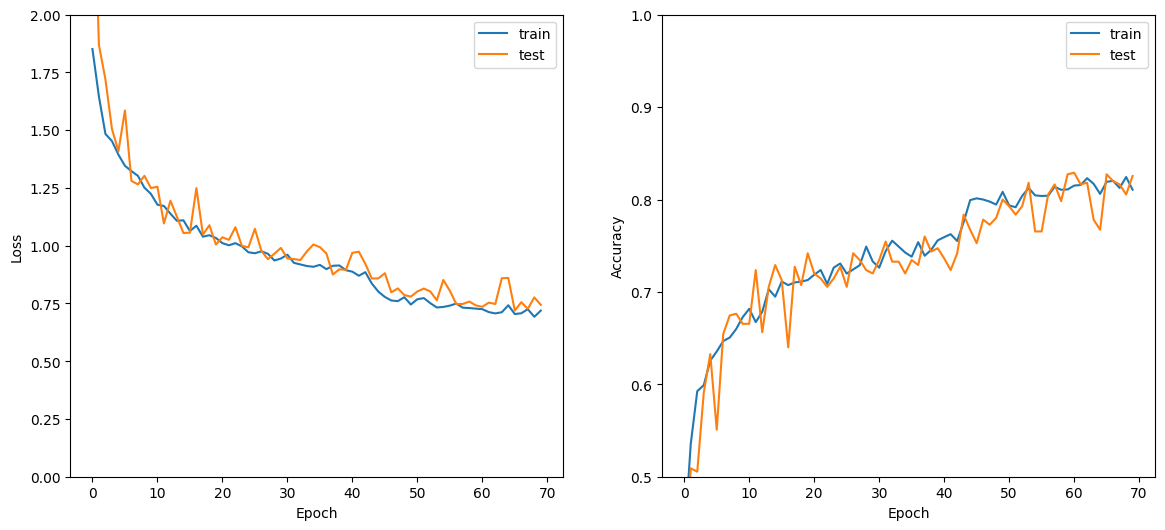

In [5]:
plot_history(history.history)
save(history, model, 'final')

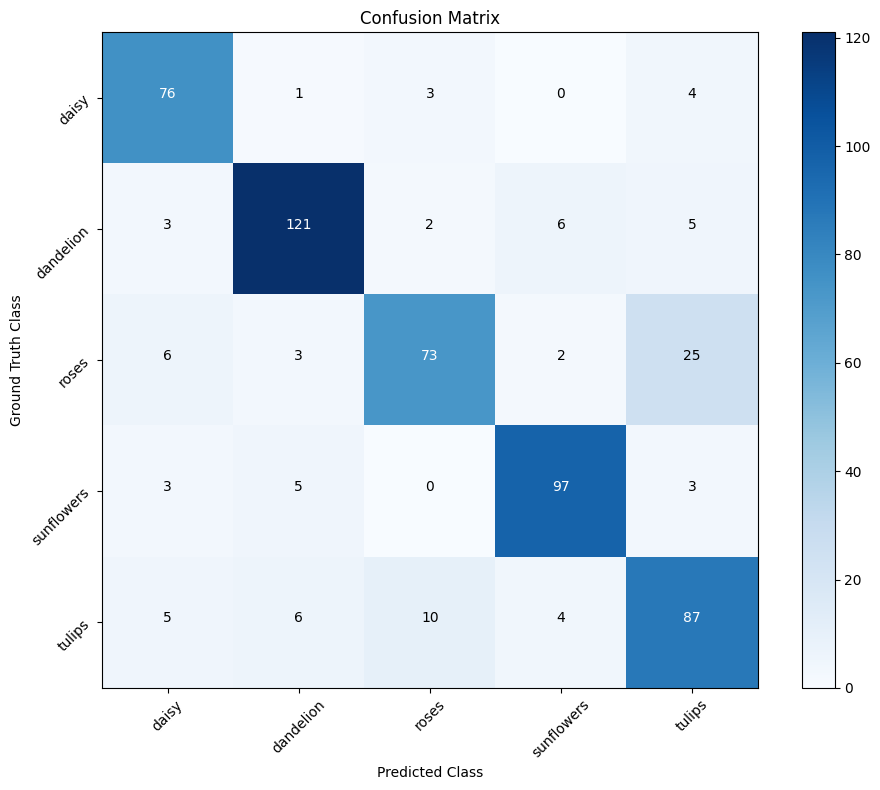

In [14]:
correct_labels, predicted_labels = print_confusion_matrix(model, test, classes)

In [15]:
# Classification report
print('Classification report:')
print(classification_report(correct_labels, predicted_labels))

Classification report:
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        84
           1       0.89      0.88      0.89       137
           2       0.83      0.67      0.74       109
           3       0.89      0.90      0.89       108
           4       0.70      0.78      0.74       112

    accuracy                           0.83       550
   macro avg       0.83      0.83      0.82       550
weighted avg       0.83      0.83      0.82       550



## Final model (gray scale)

In [13]:
# Creation of the model
regularizer = keras.regularizers.L1L2(0.0001)

inputs = keras.Input((224,224,1))

x = keras.layers.RandomFlip("horizontal_and_vertical")(inputs)
x = keras.layers.RandomRotation(0.5)(x)
x = keras.layers.RandomContrast(0.5)(x)
x = keras.layers.RandomBrightness(0.5)(x)
x = keras.layers.RandomZoom(0.2)(x)

x = keras.layers.Conv2D(64, 3, padding="same", kernel_regularizer=regularizer)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(64, 3, padding="same", kernel_regularizer=regularizer)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(128, 3, padding="same", kernel_regularizer=regularizer)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.GlobalMaxPooling2D()(x)

x = keras.layers.Dense(64, activation="relu", kernel_regularizer=regularizer, kernel_initializer=keras.initializers.HeNormal())(x)
x = keras.layers.Dense(64, activation="relu", kernel_regularizer=regularizer, kernel_initializer=keras.initializers.HeNormal())(x)
x = keras.layers.Dense(16, activation="relu", kernel_regularizer=regularizer, kernel_initializer=keras.initializers.HeNormal())(x)

outputs = keras.layers.Dense(len(classes), activation="softmax", kernel_regularizer=regularizer)(x)
model = keras.Model(inputs, outputs)

# Compile the model
model.compile(optimizer=keras.optimizers.Adam(), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Callbacks
callbacks = [
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
]

In [14]:
# Training the model
history = model.fit(trainGray, epochs=70, validation_data=testGray, batch_size=64, callbacks=callbacks)

Epoch 1/70
98/98 ━━━━━━━━━━━━━━━━━━━━ 347s 3s/step - accuracy: 0.2352 - loss: 2.3725 - val_accuracy: 0.1527 - val_loss: 3.2022 - learning_rate: 0.0010
Epoch 2/70
98/98 ━━━━━━━━━━━━━━━━━━━━ 288s 3s/step - accuracy: 0.3147 - loss: 2.0167 - val_accuracy: 0.2945 - val_loss: 2.0694 - learning_rate: 0.0010
Epoch 3/70
98/98 ━━━━━━━━━━━━━━━━━━━━ 273s 3s/step - accuracy: 0.3532 - loss: 1.9371 - val_accuracy: 0.3745 - val_loss: 1.8794 - learning_rate: 0.0010
Epoch 4/70
98/98 ━━━━━━━━━━━━━━━━━━━━ 287s 3s/step - accuracy: 0.3647 - loss: 1.8995 - val_accuracy: 0.4236 - val_loss: 1.7790 - learning_rate: 0.0010
Epoch 5/70
98/98 ━━━━━━━━━━━━━━━━━━━━ 310s 3s/step - accuracy: 0.4025 - loss: 1.8434 - val_accuracy: 0.3709 - val_loss: 1.8483 - learning_rate: 0.0010
Epoch 6/70
98/98 ━━━━━━━━━━━━━━━━━━━━ 294s 3s/step - accuracy: 0.3985 - loss: 1.8099 - val_accuracy: 0.4018 - val_loss: 1.7825 - learning_rate: 0.0010
Epoch 7/70
98/98 ━━━━━━━━━━━━━━━━━━━━ 297s 3s/step - accuracy: 0.4187 - loss: 1.7410 - val_acc

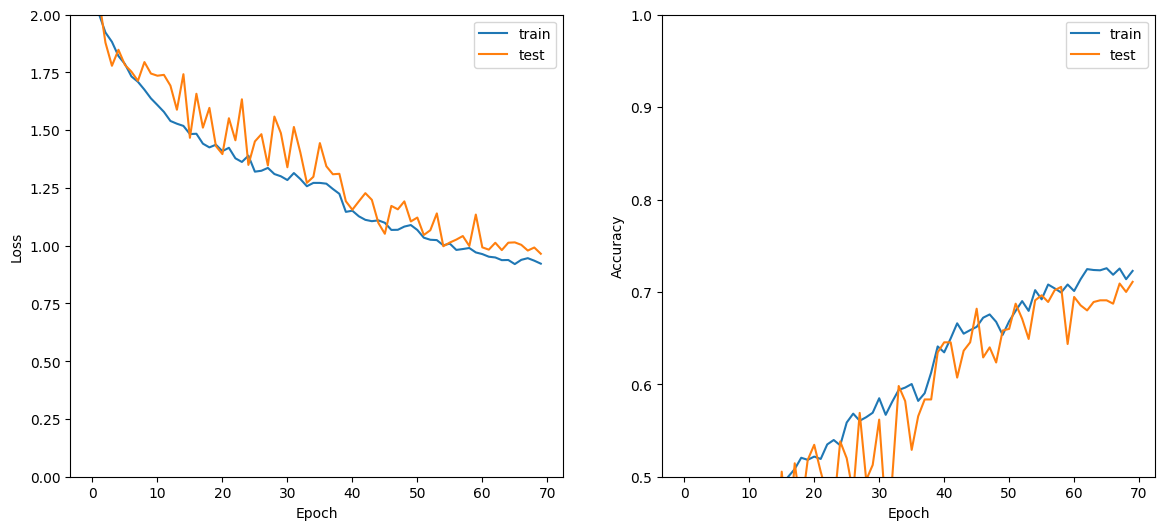

In [6]:
plot_history(history.history)
save(history, model, 'grayscale')

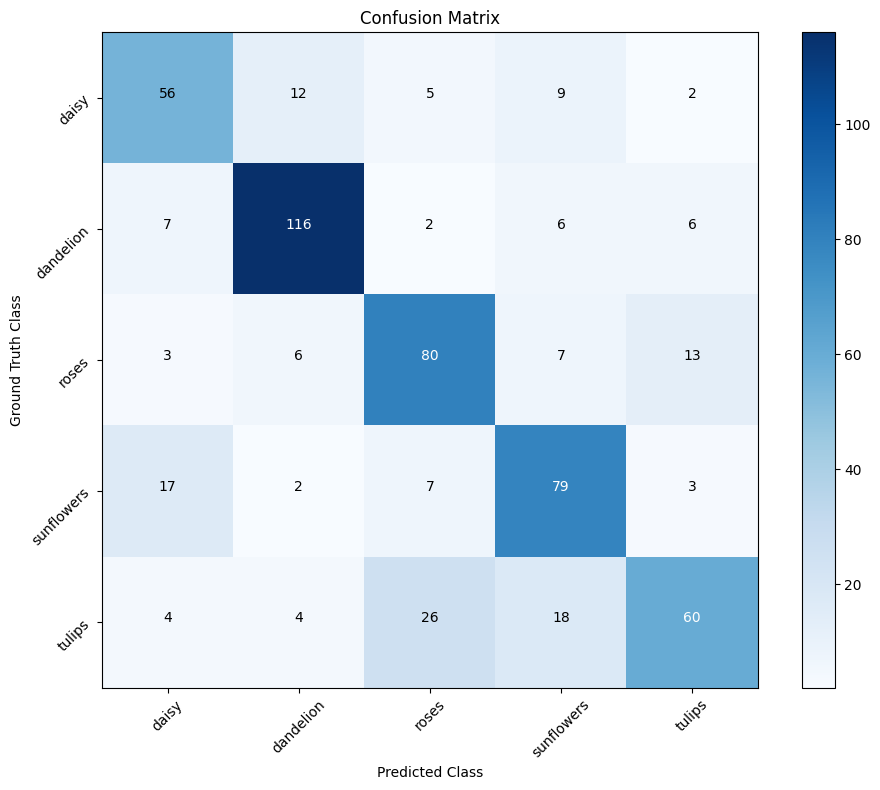

In [21]:
correct_labels, predicted_labels = print_confusion_matrix(model, test, classes)

In [22]:
# Classification report
print('Classification report:')
print(classification_report(correct_labels, predicted_labels))

Classification report:
              precision    recall  f1-score   support

           0       0.64      0.67      0.65        84
           1       0.83      0.85      0.84       137
           2       0.67      0.73      0.70       109
           3       0.66      0.73      0.70       108
           4       0.71      0.54      0.61       112

    accuracy                           0.71       550
   macro avg       0.70      0.70      0.70       550
weighted avg       0.71      0.71      0.71       550



## Final model with dropout

### Model Building, Compilation, and Training

The following code snippet performs several key tasks:
- Defines a CNN architecture with data augmentation.
- Compiles the model with an appropriate loss function, optimizer, and evaluation metrics.
- Sets up training callbacks to enhance the training process.

### 1. Model Architecture

- **Purpose:** To define a CNN architecture for image classification with integrated data augmentation techniques.
- **Functionality:**
  - **Regularizer:** `keras.regularizers.L1L2(0.0001)` applies both L1 and L2 regularization to prevent overfitting.
  - **Input Layer:** `keras.Input((224,224,3))` defines the input shape for the model (224x224 pixels, 3 color channels).
  - **Data Augmentation Layers:**
    - `keras.layers.RandomFlip("horizontal_and_vertical")`: Randomly flips the images horizontally and vertically.
    - `keras.layers.RandomRotation(0.5)`: Randomly rotates the images.
    - `keras.layers.RandomContrast(0.5)`: Randomly adjusts the contrast of the images.
    - `keras.layers.RandomBrightness(0.5)`: Randomly adjusts the brightness of the images.
  - **Convolutional Blocks:**
    - Each block consists of:
      - `keras.layers.Conv2D`: Adds a convolutional layer with specified filters (64 and 128) and kernel size (3x3), with regularization.
      - `keras.layers.BatchNormalization()`: Normalizes the output of the convolutional layer.
      - `keras.layers.Activation("relu")`: Applies the ReLU activation function.
      - `keras.layers.MaxPooling2D(3, strides=3, padding="same")`: Reduces the spatial dimensions using max pooling with a 3x3 window.
  - **Global Max Pooling:**
    - `keras.layers.GlobalMaxPooling2D()`: Reduces each feature map to a single value.
  - **Fully Connected Layers:**
    - `keras.layers.Dense`: Adds dense layers with 64, 64, and 16 units respectively, using ReLU activation, L1L2 regularization, and HeNormal initializer.
    - **Dropout Layers:** `keras.layers.Dropout(0.3)` are added after each dense layer to reduce overfitting by randomly setting a fraction of input units to 0.
    - `keras.layers.Dense(len(classes), activation="softmax", kernel_regularizer=regularizer)`: Adds an output dense layer with units equal to the number of classes, using softmax activation for classification.

In [11]:
# Creation of the model
regularizer = keras.regularizers.L1L2(0.0001)

inputs = keras.Input((224,224,3))

x = keras.layers.RandomFlip("horizontal_and_vertical")(inputs)
x = keras.layers.RandomRotation(0.5)(x)
x = keras.layers.RandomContrast(0.5)(x)
x = keras.layers.RandomBrightness(0.5)(x)

x = keras.layers.Conv2D(64, 3, padding="same", kernel_regularizer=regularizer)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(64, 3, padding="same", kernel_regularizer=regularizer)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(128, 3, padding="same", kernel_regularizer=regularizer)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.GlobalMaxPooling2D()(x)

x = keras.layers.Dense(64, activation="relu", kernel_regularizer=regularizer, kernel_initializer=keras.initializers.HeNormal())(x)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.Dense(64, activation="relu", kernel_regularizer=regularizer, kernel_initializer=keras.initializers.HeNormal())(x)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.Dense(16, activation="relu", kernel_regularizer=regularizer, kernel_initializer=keras.initializers.HeNormal())(x)
x = keras.layers.Dropout(0.3)(x)

outputs = keras.layers.Dense(len(classes), activation="softmax", kernel_regularizer=regularizer)(x)
model = keras.Model(inputs, outputs)

# Compile the model
model.compile(optimizer=keras.optimizers.Adam(), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Callbacks
callbacks = [
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
]

In [12]:
# Training the model
history = model.fit(train, epochs=70, validation_data=test, batch_size=64, callbacks=callbacks)

Epoch 1/70
98/98 ━━━━━━━━━━━━━━━━━━━━ 153s 1s/step - accuracy: 0.2094 - loss: 2.7778 - val_accuracy: 0.2764 - val_loss: 1.9815 - learning_rate: 0.0010
Epoch 2/70
98/98 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - accuracy: 0.3358 - loss: 2.0156 - val_accuracy: 0.3255 - val_loss: 2.0073 - learning_rate: 0.0010
Epoch 3/70
98/98 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.4052 - loss: 1.8724 - val_accuracy: 0.4709 - val_loss: 1.6758 - learning_rate: 0.0010
Epoch 4/70
98/98 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - accuracy: 0.4384 - loss: 1.7926 - val_accuracy: 0.5000 - val_loss: 1.6586 - learning_rate: 0.0010
Epoch 5/70
98/98 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.4572 - loss: 1.7554 - val_accuracy: 0.5273 - val_loss: 1.5997 - learning_rate: 0.0010
Epoch 6/70
98/98 ━━━━━━━━━━━━━━━━━━━━ 146s 1s/step - accuracy: 0.4854 - loss: 1.6986 - val_accuracy: 0.4782 - val_loss: 1.6337 - learning_rate: 0.0010
Epoch 7/70
98/98 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - accuracy: 0.5149 - loss: 1.6451 - val_acc

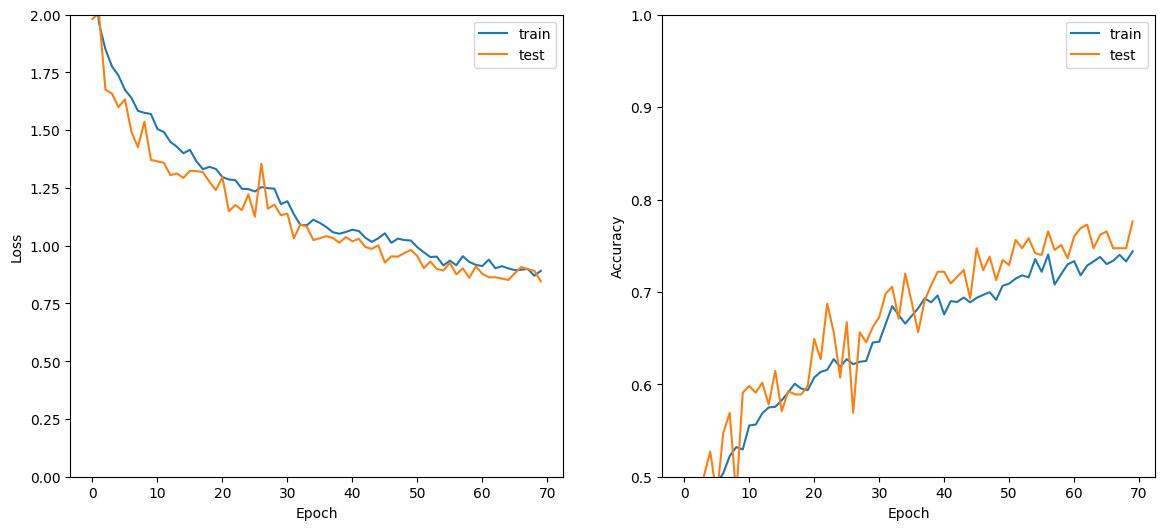

In [14]:
plot_history(history.history)
save(history, model, 'dropout')

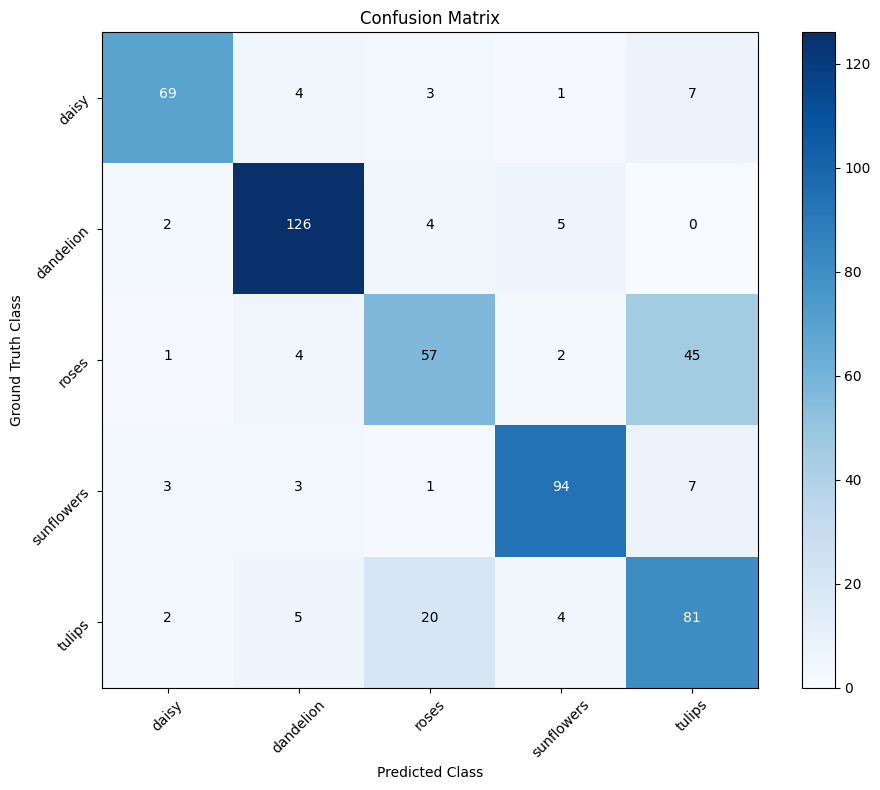

In [17]:
correct_labels, predicted_labels = print_confusion_matrix(model, test, classes)

In [18]:
# Classification report
print('Classification report:')
print(classification_report(correct_labels, predicted_labels))

Classification report:
              precision    recall  f1-score   support

           0       0.90      0.82      0.86        84
           1       0.89      0.92      0.90       137
           2       0.67      0.52      0.59       109
           3       0.89      0.87      0.88       108
           4       0.58      0.72      0.64       112

    accuracy                           0.78       550
   macro avg       0.78      0.77      0.77       550
weighted avg       0.78      0.78      0.78       550



## ResNet50v2

### Model Building, Compilation, and Training

The following code snippet performs several key tasks:
- Defines a CNN architecture using ResNet50V2 as the base model for transfer learning.
- Compiles the model with an appropriate loss function, optimizer, and evaluation metrics.
- Sets up training callbacks to enhance the training process.

### 1. Model Architecture

- **Purpose:** To define a CNN architecture for image classification using transfer learning from a pre-trained ResNet50V2 model.
- **Functionality:**
  - **Input Layer:** `keras.Input(shape=(224, 224, 3))` defines the input shape for the model (224x224 pixels, 3 color channels).
  - **Base Model:** `keras.applications.ResNet50V2(weights='imagenet', include_top=False, input_tensor=inputs)`:
    - **ResNet50V2:** A pre-trained model on ImageNet, used as the base model for feature extraction.
    - **Weights:** Loads pre-trained weights from ImageNet.
    - **Include Top:** Excludes the top fully connected layers of ResNet50V2.
    - **Input Tensor:** Uses the specified input tensor.
  - **Freezing Base Model:** `base_model.trainable = False` ensures that the weights of the base model are not updated during training.
  - **Custom Layers:** 
    - `keras.layers.GlobalAveragePooling2D()`: Applies global average pooling to reduce the spatial dimensions of the feature maps.
    - `keras.layers.Dense(64, activation='relu')`: Adds a dense layer with 64 units and ReLU activation.
    - **Output Layer:** `keras.layers.Dense(len(classes), activation='softmax')`: Adds an output dense layer with units equal to the number of classes, using softmax activation for classification.

In [6]:
inputs = keras.Input(shape=(224, 224, 3))

base_model = keras.applications.ResNet50V2(weights='imagenet', include_top=False, input_tensor=inputs)

base_model.trainable = False

x = base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(64, activation='relu')(x)
x = keras.layers.Dense(64, activation='relu')(x)
outputs = keras.layers.Dense(len(classes), activation='softmax')(x)

model = keras.models.Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer=keras.optimizers.Adam(), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Callbacks
callbacks = [
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
]

In [7]:
# Training the model
history = model.fit(train, epochs=70, validation_data=test, batch_size=64, callbacks=callbacks)

Epoch 1/70
98/98 ━━━━━━━━━━━━━━━━━━━━ 85s 824ms/step - accuracy: 0.2374 - loss: 20.5173 - val_accuracy: 0.2964 - val_loss: 4.5701 - learning_rate: 0.0010
Epoch 2/70
98/98 ━━━━━━━━━━━━━━━━━━━━ 80s 817ms/step - accuracy: 0.3848 - loss: 3.3137 - val_accuracy: 0.3527 - val_loss: 2.9888 - learning_rate: 0.0010
Epoch 3/70
98/98 ━━━━━━━━━━━━━━━━━━━━ 74s 758ms/step - accuracy: 0.4323 - loss: 2.3421 - val_accuracy: 0.3618 - val_loss: 2.9222 - learning_rate: 0.0010
Epoch 4/70
98/98 ━━━━━━━━━━━━━━━━━━━━ 75s 766ms/step - accuracy: 0.4413 - loss: 2.1358 - val_accuracy: 0.4618 - val_loss: 1.9596 - learning_rate: 0.0010
Epoch 5/70
98/98 ━━━━━━━━━━━━━━━━━━━━ 76s 777ms/step - accuracy: 0.5062 - loss: 1.5869 - val_accuracy: 0.5218 - val_loss: 1.4642 - learning_rate: 0.0010
Epoch 6/70
98/98 ━━━━━━━━━━━━━━━━━━━━ 75s 765ms/step - accuracy: 0.5269 - loss: 1.3597 - val_accuracy: 0.5055 - val_loss: 1.4236 - learning_rate: 0.0010
Epoch 7/70
98/98 ━━━━━━━━━━━━━━━━━━━━ 75s 766ms/step - accuracy: 0.5823 - loss: 1

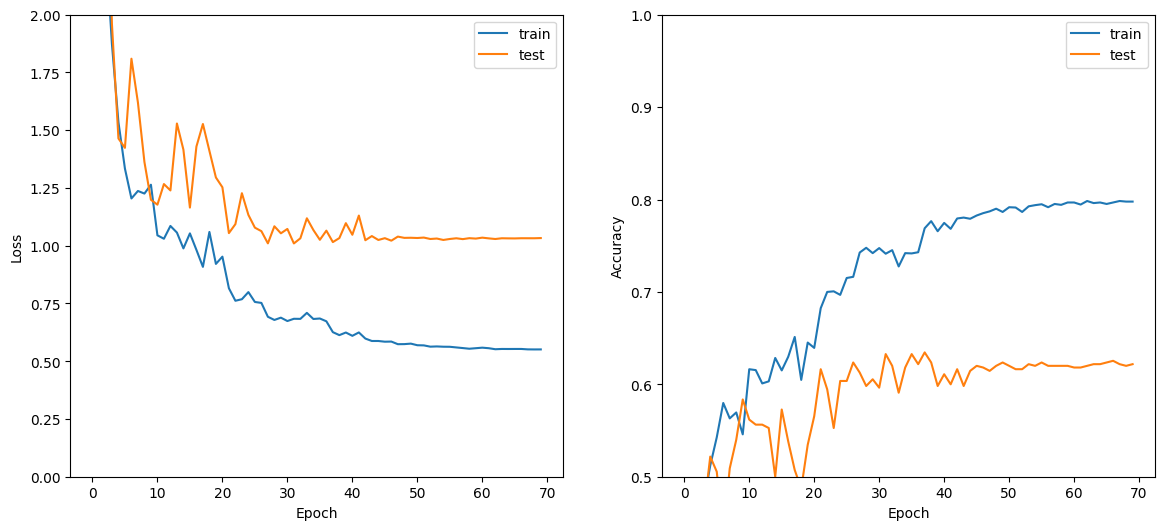

In [9]:
plot_history(history.history)
save(history, model, 'resnet50v2')

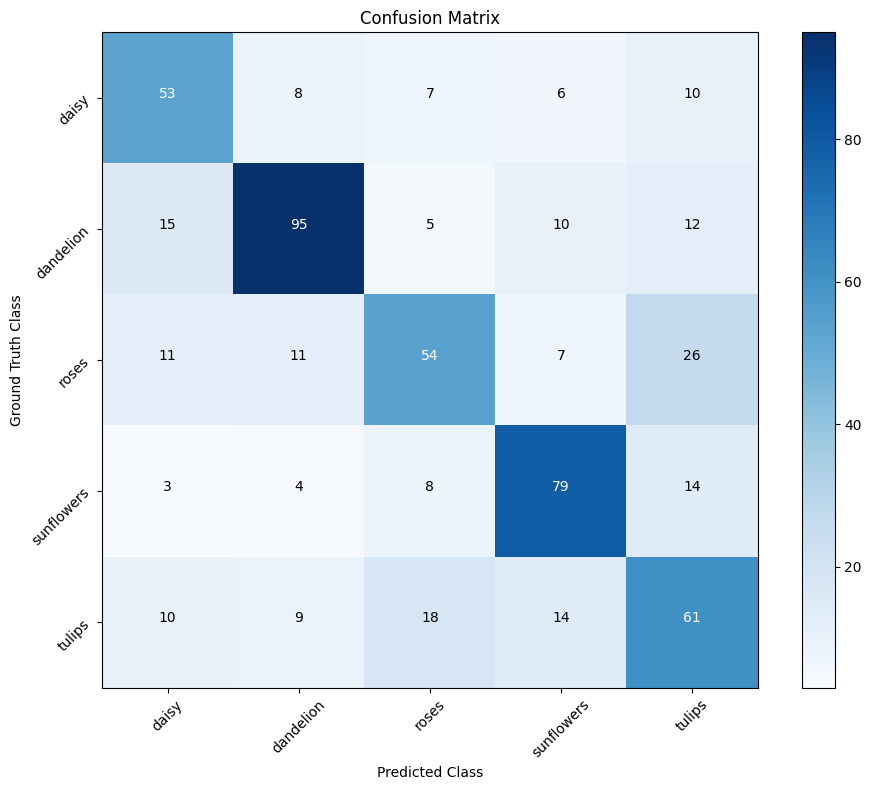

In [12]:
correct_labels, predicted_labels = print_confusion_matrix(model, test, classes)

In [13]:
# Classification report
print('Classification report:')
print(classification_report(correct_labels, predicted_labels))

Classification report:
              precision    recall  f1-score   support

           0       0.58      0.63      0.60        84
           1       0.75      0.69      0.72       137
           2       0.59      0.50      0.54       109
           3       0.68      0.73      0.71       108
           4       0.50      0.54      0.52       112

    accuracy                           0.62       550
   macro avg       0.62      0.62      0.62       550
weighted avg       0.63      0.62      0.62       550



## EfficientNetB3

### Model Building, Compilation, and Training

The following code snippet performs several key tasks:
- Defines a CNN architecture using EfficientNetB3 as the base model for transfer learning.
- Compiles the model with an appropriate loss function, optimizer, and evaluation metrics.
- Sets up training callbacks to enhance the training process.

### 1. Model Architecture

- **Purpose:** To define a CNN architecture for image classification using transfer learning from a pre-trained EfficientNetB3 model.
- **Functionality:**
  - **Input Layer:** `keras.Input(shape=(224, 224, 3))` defines the input shape for the model (224x224 pixels, 3 color channels).
  - **Base Model:** `keras.applications.EfficientNetB3(weights='imagenet', include_top=False, input_tensor=inputs)`:
    - **EfficientNetB3:** A pre-trained model on ImageNet, used as the base model for feature extraction.
    - **Weights:** Loads pre-trained weights from ImageNet.
    - **Include Top:** Excludes the top fully connected layers of EfficientNetB3.
    - **Input Tensor:** Uses the specified input tensor.
  - **Freezing Base Model:** `base_model.trainable = False` ensures that the weights of the base model are not updated during training.
  - **Custom Layers:** 
    - `keras.layers.GlobalAveragePooling2D()`: Applies global average pooling to reduce the spatial dimensions of the feature maps.
    - `keras.layers.Dense(64, activation='relu')`: Adds a dense layer with 64 units and ReLU activation.
    - **Output Layer:** `keras.layers.Dense(len(classes), activation='softmax')`: Adds an output dense layer with units equal to the number of classes, using softmax activation for classification.

In [16]:
inputs = keras.Input(shape=(224, 224, 3))

base_model = keras.applications.EfficientNetB3(weights='imagenet', include_top=False, input_tensor=inputs)

base_model.trainable = False

x = base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(64, activation='relu')(x)
x = keras.layers.Dense(64, activation='relu')(x)
outputs = keras.layers.Dense(len(classes), activation='softmax')(x)

model = keras.models.Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer=keras.optimizers.Adam(), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Callbacks
callbacks = [
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
]

In [17]:
# Training the model
history = model.fit(train, epochs=70, validation_data=test, batch_size=64, callbacks=callbacks)

Epoch 1/70
98/98 ━━━━━━━━━━━━━━━━━━━━ 100s 919ms/step - accuracy: 0.7415 - loss: 0.7450 - val_accuracy: 0.9018 - val_loss: 0.2633 - learning_rate: 0.0010
Epoch 2/70
98/98 ━━━━━━━━━━━━━━━━━━━━ 88s 897ms/step - accuracy: 0.9123 - loss: 0.2520 - val_accuracy: 0.9055 - val_loss: 0.2717 - learning_rate: 0.0010
Epoch 3/70
98/98 ━━━━━━━━━━━━━━━━━━━━ 88s 897ms/step - accuracy: 0.9502 - loss: 0.1595 - val_accuracy: 0.9218 - val_loss: 0.2442 - learning_rate: 0.0010
Epoch 4/70
98/98 ━━━━━━━━━━━━━━━━━━━━ 88s 897ms/step - accuracy: 0.9688 - loss: 0.1067 - val_accuracy: 0.9182 - val_loss: 0.2557 - learning_rate: 0.0010
Epoch 5/70
98/98 ━━━━━━━━━━━━━━━━━━━━ 88s 899ms/step - accuracy: 0.9701 - loss: 0.1014 - val_accuracy: 0.9109 - val_loss: 0.2830 - learning_rate: 0.0010
Epoch 6/70
98/98 ━━━━━━━━━━━━━━━━━━━━ 88s 899ms/step - accuracy: 0.9788 - loss: 0.0756 - val_accuracy: 0.9055 - val_loss: 0.3076 - learning_rate: 0.0010
Epoch 7/70
98/98 ━━━━━━━━━━━━━━━━━━━━ 88s 900ms/step - accuracy: 0.9805 - loss: 0

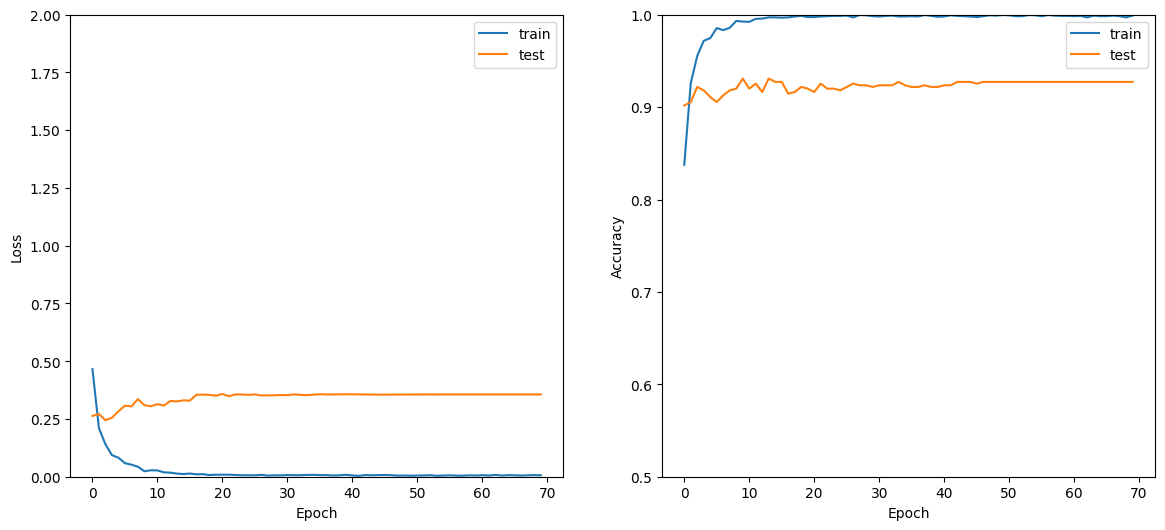

In [19]:
plot_history(history.history)
save(history, model, 'efficientNetB3')

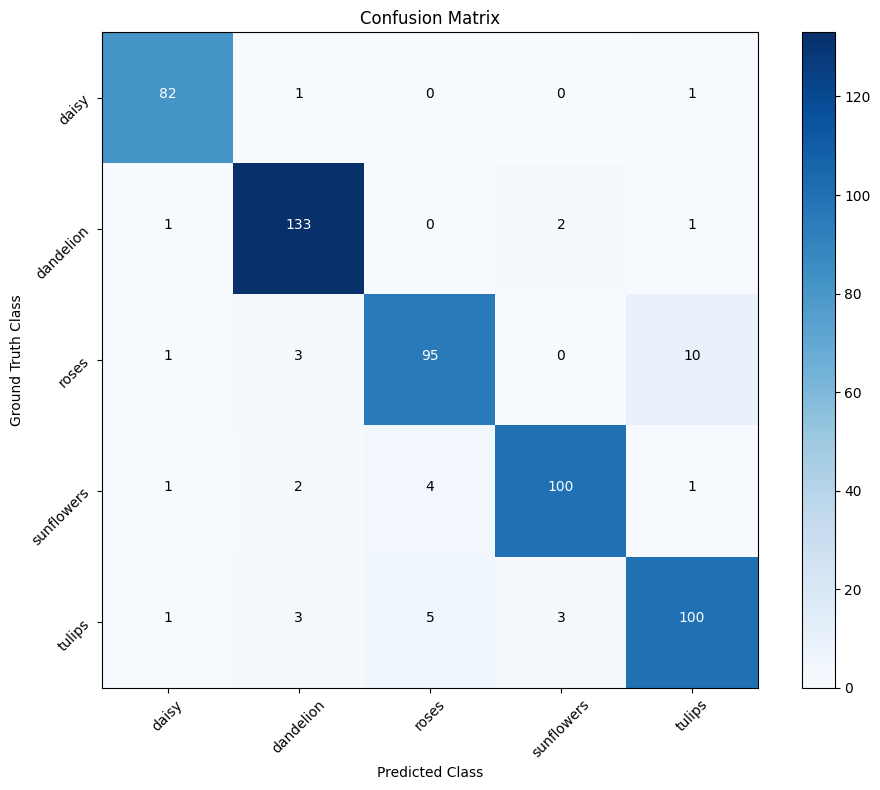

In [22]:
correct_labels, predicted_labels = print_confusion_matrix(model, test, classes)

In [23]:
# Classification report
print('Classification report:')
print(classification_report(correct_labels, predicted_labels))

Classification report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.96        84
           1       0.94      0.97      0.95       137
           2       0.91      0.87      0.89       109
           3       0.95      0.93      0.94       108
           4       0.88      0.89      0.89       112

    accuracy                           0.93       550
   macro avg       0.93      0.93      0.93       550
weighted avg       0.93      0.93      0.93       550



# Output of predictions

In [5]:
model = keras.models.load_model('final.keras')

### Outputs of predictions
Post-processing and visualization after making predictions on a test dataset.

**1. Unbatching the Dataset**

- **Purpose:** To unbatch the test dataset to access individual images and labels for further processing.
- **Functionality:**
  - **Looping Through Dataset:** Iterates through each batch of images and labels in the `test` dataset.
  - **Appending to Lists:** Appends each image and label to separate lists (`images` and `labels`).
  - **Conversion to NumPy Arrays:** Converts the lists of images and labels into NumPy arrays for further manipulation.

**2. Selecting a Sample of Images**

- **Purpose:** To select a subset of images for prediction and visualization.
- **Functionality:**
  - **Random Selection:** Randomly selects 80 images from the unbatched test dataset.
  - **Indexing:** Retrieves the selected images and their corresponding labels.
  - **Ensuring Sufficient Predictions:** Ensures a sufficient number of images for correct predictions for visualization purposes.

**3. Making Predictions**

- **Purpose:** To make predictions on the selected subset of images using the trained model.
- **Functionality:**
  - **Model Prediction:** Uses the trained model to predict classes for the selected images.
  - **Converting to Labels:** Converts one-hot encoded labels to single labels for comparison.

**4. Filtering Correctly Predicted Images**

- **Purpose:** To filter out correctly predicted images for visualization.
- **Functionality:**
  - **Iterating Through Predictions:** Iterates through each prediction.
  - **Filtering Correct Predictions:** Checks if the predicted label matches the true label.
  - **Storing Correct Predictions:** Stores correctly predicted images, true labels, and predicted classes for visualization.

**5. Visualizing Correctly Predicted Images**

- **Purpose:** To visualize a subset of correctly predicted images along with their true and predicted labels.
- **Functionality:**
  - **Visualization Function:** Calls `plot_images_with_predictions` function to display images with labels.
  - **Inputs:** Passes the subset of correctly predicted images, true labels, and predicted classes for visualization.

This code segment enables post-processing and visualization of predictions made by the model on a subset of the test dataset, allowing for analysis of the model's performance.

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


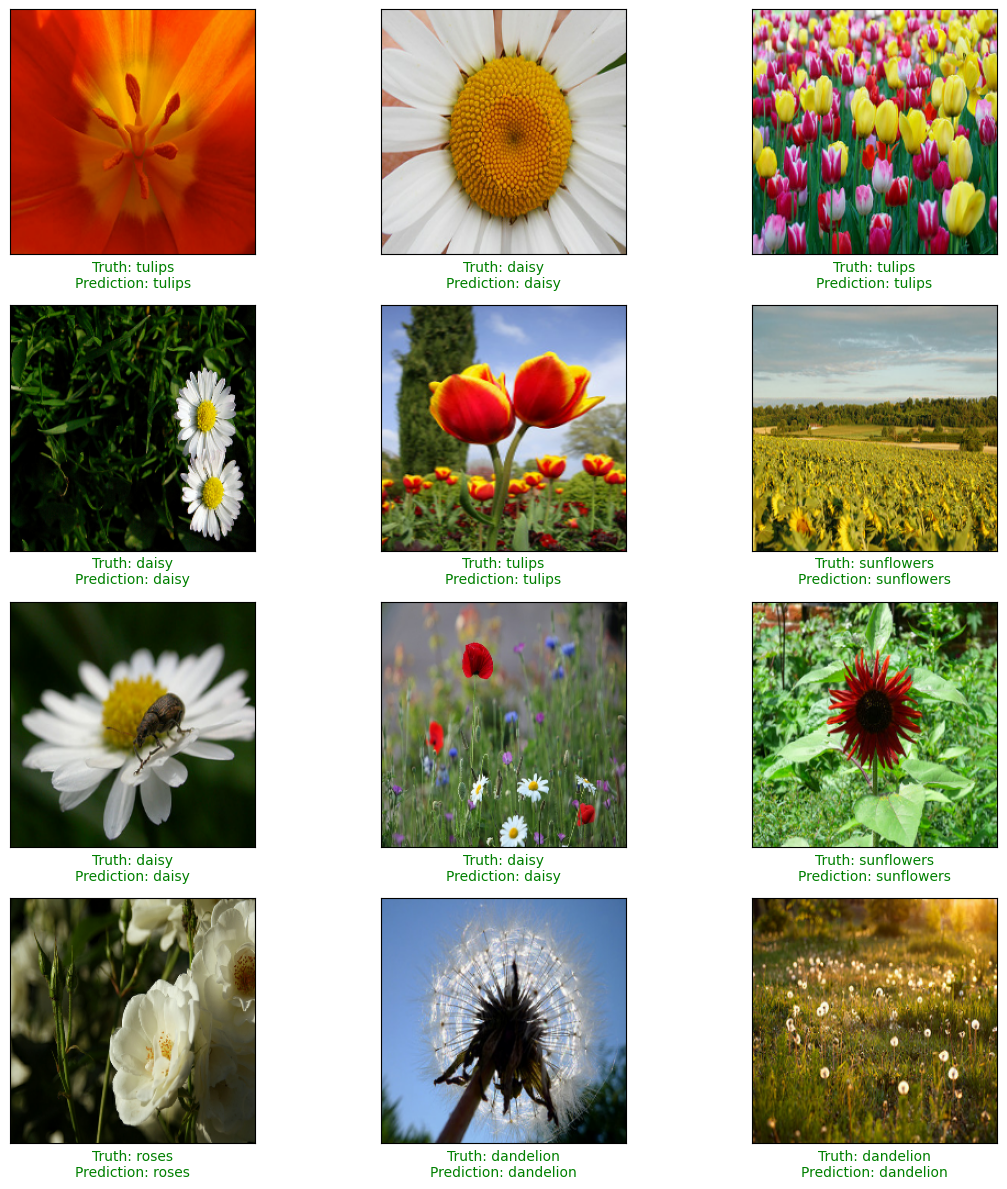

In [53]:
# Unbatch the dataset (because the batched version contains only 18 images)
images = []
labels = []
for image_batch, label_batch in test.unbatch():
    images.append(image_batch.numpy())
    labels.append(label_batch.numpy())

images = np.array(images)
labels = np.array(labels)

# Take a sample of 80 images (in order to have a sufficient number of correct predictions)
num_images = 80
random_indices = random.sample(range(len(images)), num_images)
selected_images = images[random_indices]
selected_labels_one_hot = labels[random_indices]

# Make predictions
predicted_probabilities = model.predict(selected_images)
predicted_classes = np.argmax(predicted_probabilities, axis=-1)
true_labels = np.argmax(selected_labels_one_hot, axis=-1)

# Filter images
correct_images = []
correct_true_labels = []
correct_predicted_classes = []

for i in range(len(selected_images)):
    if true_labels[i] == predicted_classes[i]:
        correct_images.append(selected_images[i])
        correct_true_labels.append(true_labels[i])
        correct_predicted_classes.append(predicted_classes[i])

num_correct_images_to_display = min(12, len(correct_images))

plot_images_with_predictions(correct_images[:num_correct_images_to_display], correct_true_labels[:num_correct_images_to_display], correct_predicted_classes[:num_correct_images_to_display], classes)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


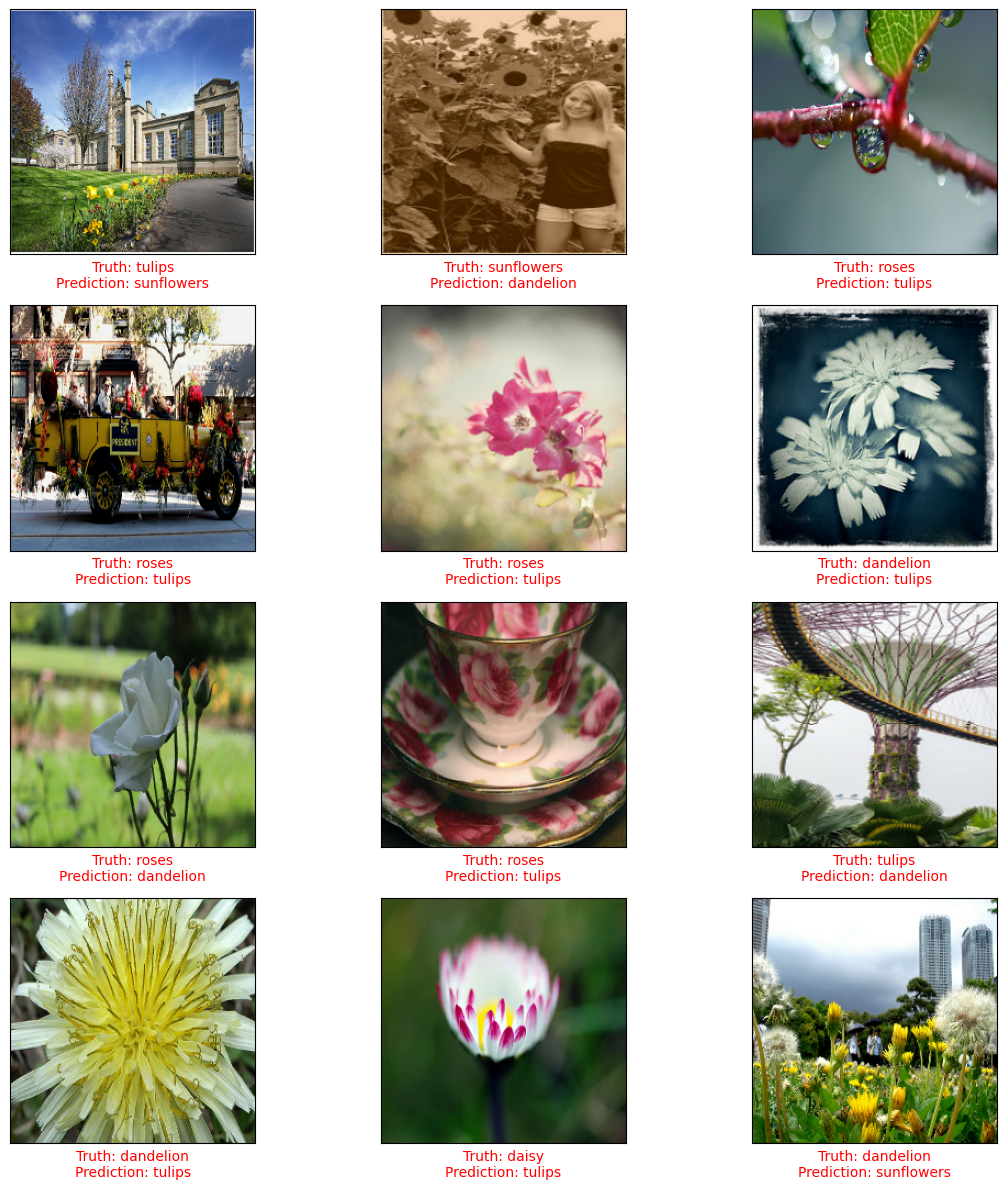

In [27]:
# unbatch the dataset (because the batched version contain only 18 images)
images = []
labels = []
for image_batch, label_batch in test.unbatch():
    images.append(image_batch.numpy())
    labels.append(label_batch.numpy())

images = np.array(images)
labels = np.array(labels)

# Take a sample of 80 images (in order to have sufficient number of wrong predictions)
num_images = 80
random_indices = random.sample(range(len(images)), num_images)
selected_images = images[random_indices]
selected_labels_one_hot = labels[random_indices]

# Make predictions
predicted_probabilities = model.predict(selected_images)
predicted_classes = np.argmax(predicted_probabilities, axis=-1)
true_labels = np.argmax(selected_labels_one_hot, axis=-1)

# Filter images
wrong_images = []
wrong_true_labels = []
wrong_predicted_classes = []

for i in range(len(selected_images)):
    if true_labels[i] != predicted_classes[i]:
        wrong_images.append(selected_images[i])
        wrong_true_labels.append(true_labels[i])
        wrong_predicted_classes.append(predicted_classes[i])

num_wrong_images_to_display = min(12, len(wrong_images))

plot_images_with_predictions(wrong_images[:num_wrong_images_to_display], wrong_true_labels[:num_wrong_images_to_display], wrong_predicted_classes[:num_wrong_images_to_display], classes)

Found 43 files belonging to 5 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


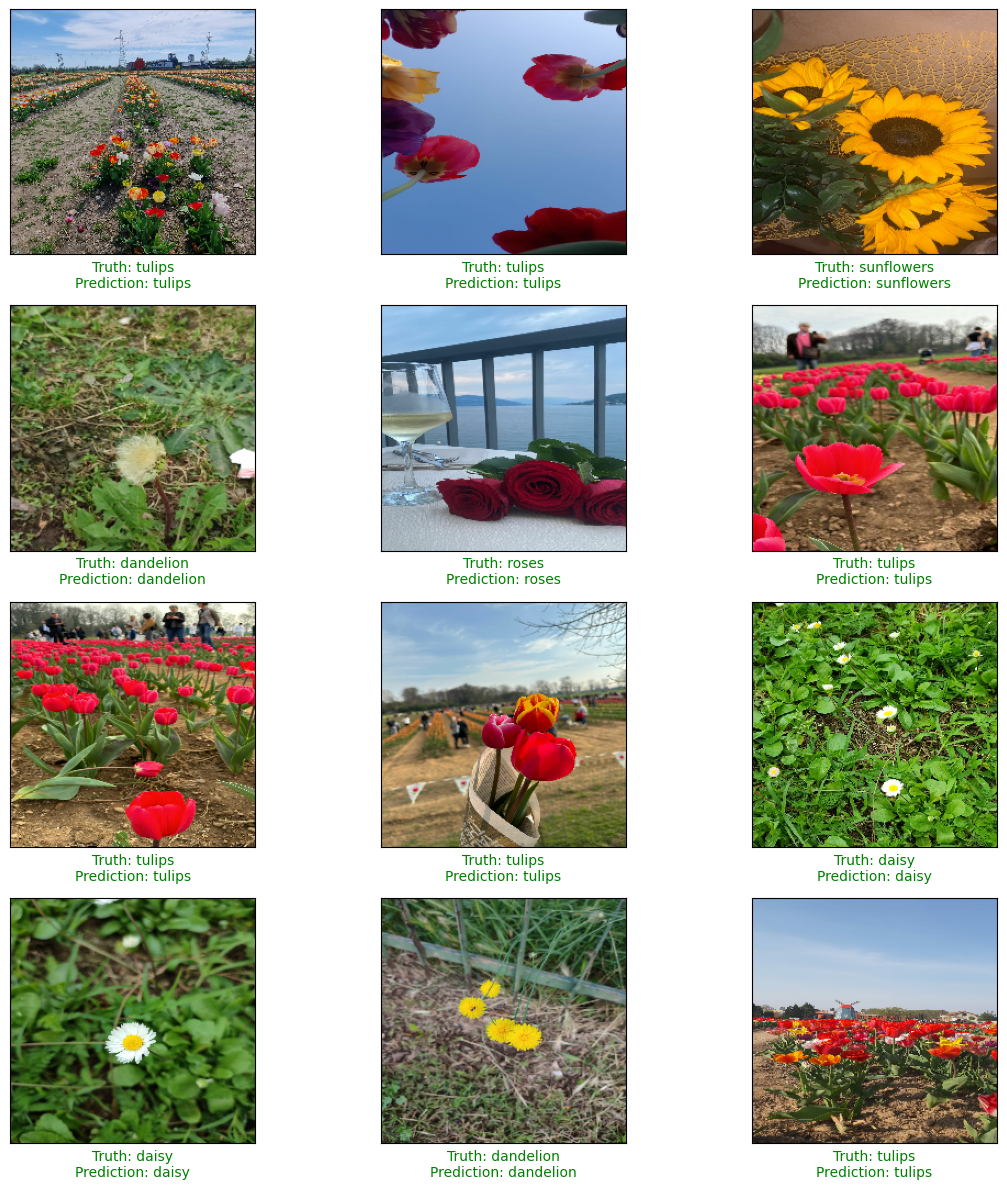

In [63]:
path = "ourDataset/flower_photos"
subfolders = glob.glob(pathname = f'{path}/*', recursive = True)

classes = []

for subfolder in subfolders:
    classes.append(subfolder.split(f'{path}\\')[1])

test = keras.utils.image_dataset_from_directory(path,
                                                image_size=(224, 224),
                                                label_mode='categorical',
                                                shuffle=True,
                                                seed=0)

# Unbatch the dataset 
images = []
labels = []
for image_batch, label_batch in test.unbatch():
    images.append(image_batch.numpy())
    labels.append(label_batch.numpy())

images = np.array(images)
labels = np.array(labels)

# Take a sample of 12 images
num_images = 12
random_indices = random.sample(range(len(images)), num_images)
selected_images = images[random_indices]
selected_labels_one_hot = labels[random_indices]

# Make predictions
predicted_probabilities = model.predict(selected_images)
predicted_classes = np.argmax(predicted_probabilities, axis=-1)
true_labels = np.argmax(selected_labels_one_hot, axis=-1)

# Visualize the results
plot_images_with_predictions(selected_images, true_labels, predicted_classes, classes)

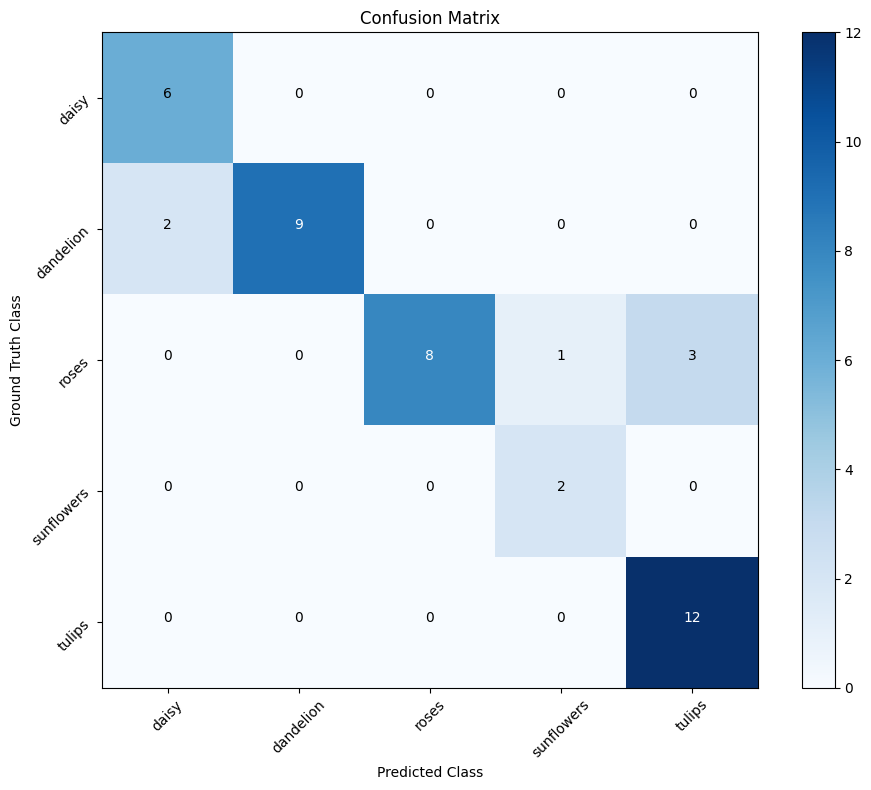

In [64]:
correct_labels, predicted_labels = print_confusion_matrix(model, test, classes)

In [65]:
# Classification report
print('Classification report:')
print(classification_report(correct_labels, predicted_labels))

Classification report:
              precision    recall  f1-score   support

           0       0.75      1.00      0.86         6
           1       1.00      0.82      0.90        11
           2       1.00      0.67      0.80        12
           3       0.67      1.00      0.80         2
           4       0.80      1.00      0.89        12

    accuracy                           0.86        43
   macro avg       0.84      0.90      0.85        43
weighted avg       0.89      0.86      0.86        43



# Cleaned dataset model

In [21]:
# Creation of a new dataset (only training and test set)
path = "dataset/cleaned_flower_photos"
subfolders = glob.glob(pathname = f'{path}/*', recursive = True)

classes = []

for subfolder in subfolders:
    classes.append(subfolder.split(f'{path}\\')[1])

train, test = keras.utils.image_dataset_from_directory(path,
                                                       image_size=(224,224),
                                                       batch_size=32,
                                                       label_mode='categorical',
                                                       subset='both',
                                                       validation_split = 0.15,
                                                       shuffle=True,
                                                       seed=0)

Found 3536 files belonging to 5 classes.
Using 3006 files for training.
Using 530 files for validation.


In [22]:
# Creation of the model
regularizer = keras.regularizers.L1L2(0.0001)

inputs = keras.Input((224,224,3))

x = keras.layers.RandomFlip("horizontal_and_vertical")(inputs)
x = keras.layers.RandomRotation(0.5)(x)
x = keras.layers.RandomContrast(0.5)(x)
x = keras.layers.RandomBrightness(0.5)(x)
x = keras.layers.RandomZoom(0.2)(x)

x = keras.layers.Conv2D(64, 3, padding="same", kernel_regularizer=regularizer)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(64, 3, padding="same", kernel_regularizer=regularizer)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(128, 3, padding="same", kernel_regularizer=regularizer)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.GlobalMaxPooling2D()(x)

x = keras.layers.Dense(64, activation="relu", kernel_regularizer=regularizer, kernel_initializer=keras.initializers.HeNormal())(x)
x = keras.layers.Dense(64, activation="relu", kernel_regularizer=regularizer, kernel_initializer=keras.initializers.HeNormal())(x)
x = keras.layers.Dense(16, activation="relu", kernel_regularizer=regularizer, kernel_initializer=keras.initializers.HeNormal())(x)

outputs = keras.layers.Dense(len(classes), activation="softmax", kernel_regularizer=regularizer)(x)
model = keras.Model(inputs, outputs)

# Compile the model
model.compile(optimizer=keras.optimizers.Adam(), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Callbacks
callbacks = [
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
]

In [23]:
# Training the model
history = model.fit(train, epochs=70, validation_data=test, batch_size=64, callbacks=callbacks)

Epoch 1/70
94/94 ━━━━━━━━━━━━━━━━━━━━ 243s 2s/step - accuracy: 0.3914 - loss: 2.0244 - val_accuracy: 0.3604 - val_loss: 2.5038 - learning_rate: 0.0010
Epoch 2/70
94/94 ━━━━━━━━━━━━━━━━━━━━ 164s 2s/step - accuracy: 0.5658 - loss: 1.5697 - val_accuracy: 0.5453 - val_loss: 1.6204 - learning_rate: 0.0010
Epoch 3/70
94/94 ━━━━━━━━━━━━━━━━━━━━ 161s 2s/step - accuracy: 0.6256 - loss: 1.4379 - val_accuracy: 0.5906 - val_loss: 1.4171 - learning_rate: 0.0010
Epoch 4/70
94/94 ━━━━━━━━━━━━━━━━━━━━ 167s 2s/step - accuracy: 0.6095 - loss: 1.4192 - val_accuracy: 0.5038 - val_loss: 1.7165 - learning_rate: 0.0010
Epoch 5/70
94/94 ━━━━━━━━━━━━━━━━━━━━ 162s 2s/step - accuracy: 0.6184 - loss: 1.3998 - val_accuracy: 0.6755 - val_loss: 1.2355 - learning_rate: 0.0010
Epoch 6/70
94/94 ━━━━━━━━━━━━━━━━━━━━ 160s 2s/step - accuracy: 0.6190 - loss: 1.3582 - val_accuracy: 0.6377 - val_loss: 1.4330 - learning_rate: 0.0010
Epoch 7/70
94/94 ━━━━━━━━━━━━━━━━━━━━ 161s 2s/step - accuracy: 0.6481 - loss: 1.3000 - val_acc

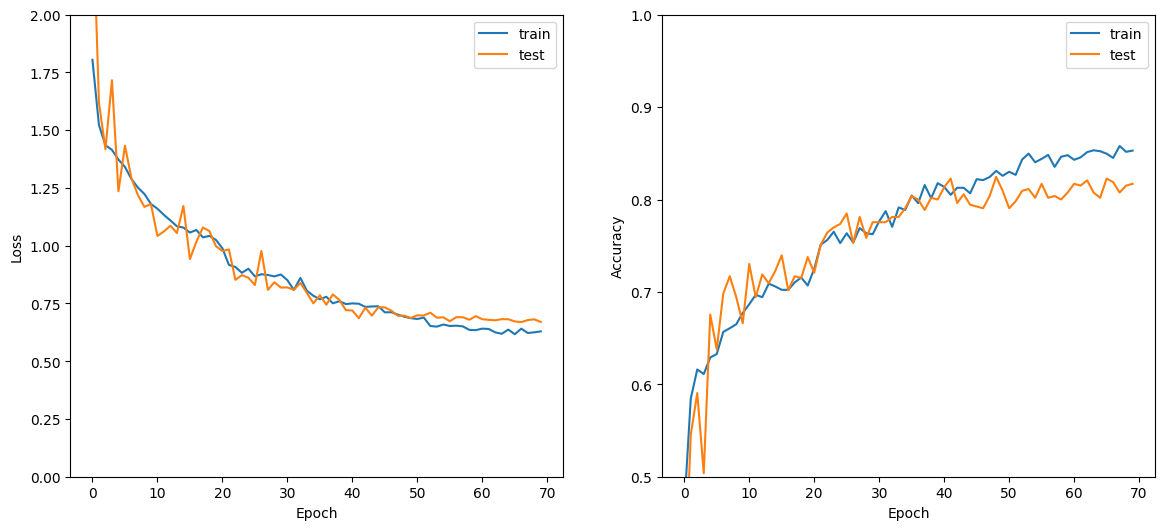

In [24]:
plot_history(history.history)
save(history, model, 'final_cleaned')

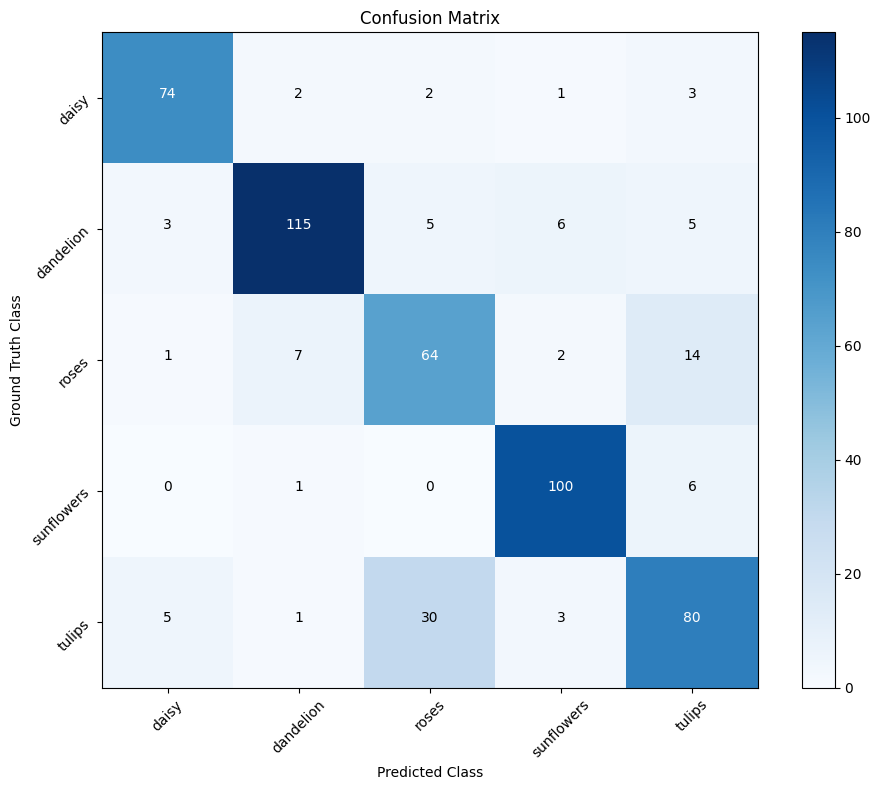

In [25]:
correct_labels, predicted_labels = print_confusion_matrix(model, test, classes)

In [26]:
# Classification report
print('Classification report:')
print(classification_report(correct_labels, predicted_labels))

Classification report:
              precision    recall  f1-score   support

           0       0.89      0.90      0.90        82
           1       0.91      0.86      0.88       134
           2       0.63      0.73      0.68        88
           3       0.89      0.93      0.91       107
           4       0.74      0.67      0.70       119

    accuracy                           0.82       530
   macro avg       0.81      0.82      0.82       530
weighted avg       0.82      0.82      0.82       530

